# Table of contents
1. [Proyect Overview](#introduction)
2. [Import Libraries and Functions](#paragraph1)
3. [Clean and Merge Dataframes](#paragraph2)
    1. [Dataframe 1: Standard Stats](#subparagraph1)
    2. [Dataframe 2: Latest Salary](#subparagraph2)
    3. [Dataframe 3: Advanced GK stats](#subparagraph3)
    4. [Dataframe 4: Advanced Goal and Shot Creation Stats](#subparagraph4)
    5. [Dataframe 5: Pass Types](#subparagraph5)
    6. [Dataframe 6: Shooting Stats](#subparagraph6)
    7. [Dataframe 7: Defensive Actions Stats](#subparagraph7)
    8. [Dataframe 8: Goalkeeper Stats](#subparagraph8)
    9. [Dataframe 9: Miscelleanous Stats](#subparagraph9)
    10. [Dataframe 10: Passing Stats](#subparagraph10)
    11. [Dataframe 11: Playing Time Stats](#subparagraph11)
    12. [Dataframe 12: Possession Stats](#subparagraph12)
    13. [Dataframe 13: Team Wages](#subparagraph13)
    14. [Dataframe 14: Standard Stats 2020, 2021, 2022](#subparagraph14)    
4. [EDA of Combined Dataframe](#paragraph3)
    1. [Players: Drop NaNs](#subparagraph1)
    2. [Nations: Top 10 and OHE](#subparagraph2)
    3. [Postions: Nulls, NaNs and OHE](#subparagraph3)
    4. [Squad: NaNs and Grouping](#subparagraph4)
    5. [Competition: NaNs and OHE](#subparagraph5)
    6. [Team Wages: NaNs and Encode](#subparagraph6)
5. [Baselines and Feature Intercorrelation](#paragraph4)
    1. [Regressor Baseline](#subparagraph1)
6. [Sal 17 Specific Modeling](#paragraph5)

<a id="introduction"></a>
## Proyect Overview

Analysis of the Five Big European Football Leagues to determine if player stats can be used to predict wages in the current year, three successive years and also whether a player will still be active three and five years years hence. 

According to a 2016 FIFPro study, the average global length of contracts is 22.6 months and for players earning over $100,000 that number goes up to approximately 32 months. The average length of contract in the data included in the Capology scrape is 2.65 years therefore a three year salary prediction seems appropriately interesting for the scope of this study therefore a starting point of 2017 was preferred over 2016 so as to be as current as possible whilst avoiding Covid related anomalies in contract restructuring.

Whilst the average contract in the dataset is under three years, the big five year contracts make the headlines especially for aging stars. A five year prediction as to whether players remain in the league will also form a part of this study.

The probative value of this study hopefully also allow us to identify players that are under and overvalued as well determine the return on investment on above average length renewal contracts.

## Import Libraries and Functions <a id="paragraph1"></a>
These are the libraries and functions imported in this notebook. Tested in Python 3.10.6.

In [98]:
import pandas as pd
from pandas import MultiIndex, Int64Index, Int16Dtype
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.graph_objects as go
import seaborn as sns

from sklearn import preprocessing
from sklearn import linear_model, metrics, model_selection

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
le = preprocessing.LabelEncoder()

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingGridSearchCV, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, RepeatedKFold

import lightgbm as lgb
import xgboost
from xgboost import XGBRegressor, XGBRFRegressor

from sklearn.metrics import mean_squared_error, accuracy_score

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

import eli5
import pickle

import warnings
warnings.filterwarnings("ignore")

In [99]:
# %load functions.py
def compileNANcols(DF):
    global NANlist
    NANlist = []
    NANlist = list(DF.columns[DF.isnull().any()])
    return NANlist

def imputeNANs(DF, col):
    X = DF[col].values.reshape(-1,1)
    imputer = KNNImputer(
            missing_values = np.nan,
            n_neighbors=3, 
            copy=False
            )
    imputer.fit(X)
    Xtrans = imputer.transform(X)
    DF[col] = Xtrans.ravel().tolist()

def cleanupDF(DF):    
    compileNANcols(DF)
    for col in NANlist:
        imputeNANs(DF, col)

def save_results(model, param_notes):
    models_summary.loc[len(models_summary)] = [y.name, model, model.score(X_test, y_test), param_notes]

## Clean and Merge Dataframes <a id="paragraph2"></a>
15 dataframes are to be imported, cleaned and merged. Baseline player stats from the Big 5 have been imported from FBref.com. Salary information is from Capology.com thanks to a an engineered scrape by GitHub user eddwebster.

### Dataframe 1: Standard Player Stats <a id="subparagraph1"></a>
Full basic stats of all players in the Big 5 leagues in 2017/18 season (herein 2017 season). 35 features are included in the original file. Of the 2691 rows (2560 unique players), 131 players are represented twice due to midseason transfers (approx. 5%). As these players stats would need to be merged correctly across the 15 dataframes' approximately 400 columns with some data dropped or augmented (team), some averaged (xAG) and some summed (goals), due to proyect time constraints all players listed twice will be removed completely. The study will therefore focus on players who in theory played the entire 2017 season with the same team. This 2429 player list from Dataframe 1 will be the unique id used when merging in the remaining dataframes.

https://fbref.com/en/comps/Big5/2017-2018/stats/players/2017-2018-Big-5-European-Leagues-Stats

In [100]:
df1 = pd.read_csv("../data/raw/fut2017standardstats.txt", header=1)
df1.head(3)

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,npxG,xAG,npxG+xAG,xG.1,xAG.1,xG+xAG,npxG.1,npxG+xAG.1,Matches,-9999
0,1,Patrick van Aanholt,nl NED,DF,Crystal Palace,eng Premier League,26.0,1990.0,28,25,...,3.1,2.1,5.2,0.13,0.09,0.21,0.13,0.21,Matches,5f09991f
1,2,Rolando Aarons,eng ENG,MFFW,Newcastle Utd,eng Premier League,21.0,1995.0,4,1,...,0.1,0.0,0.1,0.04,0.00,0.04,0.04,0.04,Matches,c5942695
2,3,Rolando Aarons,eng ENG,MFFW,Hellas Verona,it Serie A,21.0,1995.0,11,6,...,0.2,0.2,0.3,0.03,0.03,0.06,0.03,0.06,Matches,c5942695


In [101]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2691 entries, 0 to 2690
Data columns (total 35 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Rk          2691 non-null   int64  
 1   Player      2691 non-null   object 
 2   Nation      2690 non-null   object 
 3   Pos         2690 non-null   object 
 4   Squad       2691 non-null   object 
 5   Comp        2691 non-null   object 
 6   Age         2690 non-null   float64
 7   Born        2690 non-null   float64
 8   MP          2691 non-null   int64  
 9   Starts      2691 non-null   int64  
 10  Min         2691 non-null   int64  
 11  90s         2691 non-null   float64
 12  Gls         2691 non-null   int64  
 13  Ast         2691 non-null   int64  
 14  G-PK        2691 non-null   int64  
 15  PK          2691 non-null   int64  
 16  PKatt       2691 non-null   int64  
 17  CrdY        2691 non-null   int64  
 18  CrdR        2691 non-null   int64  
 19  Gls.1       2691 non-null  

In [102]:
transfers = list(df1[df1.duplicated(['Player'])]['Player'].values)
print(len(df1))
for player in transfers:
    df1.drop(df1.loc[df1['Player']==player].index, inplace=True)
len(df1)

2691


2429

In [103]:
df1.drop('Rk', axis=1, inplace=True)
df1.drop("-9999", axis=1, inplace=True)

After final merge, nation, position and competion will be encoded.  It is unclear from the glossary whether a players' position listed as FWMF or MFFW is a complete redundancy or whether it means a player with FWMF played primarily as a FW. They will be combined for encoding.

<Figure size 1400x1600 with 0 Axes>

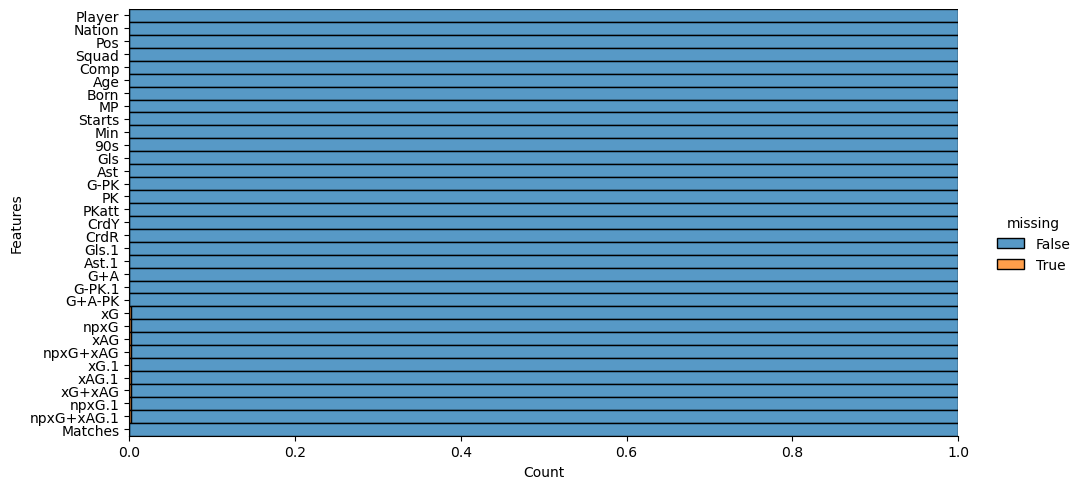

In [104]:
plt.figure(figsize=(14,16))
graph = sns.displot(data=df1.isna().melt(value_name='missing'), y='variable', hue='missing', aspect=2.0, multiple='fill')
graph.set(ylabel='Features');

In [105]:
#Nation should probably not be Imputed, let's take a closer look.
df1.loc[df1['Nation'].isna()]

,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,Min,...,xG,npxG,xAG,npxG+xAG,xG.1,xAG.1,xG+xAG,npxG.1,npxG+xAG.1,Matches
2690,Christian Rutjens,NaN,NaN,Benevento,it Serie A,NaN,NaN,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Matches


In [106]:
#Nation, Pos, Age and Born should probably not be Imputed. As there is only one
#row with missing data, let's look up from different source and complete.
df1.loc[df1.Player == 'Christian Rutjens', ['Nation', 'Pos', 'Age', 'Born']] = 'es ESP', 'DF', 19.0, '1998.0'
df1.loc[df1.Player == 'Christian Rutjens']

,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,Min,...,xG,npxG,xAG,npxG+xAG,xG.1,xAG.1,xG+xAG,npxG.1,npxG+xAG.1,Matches
2690,Christian Rutjens,es ESP,DF,Benevento,it Serie A,19.0,1998.0,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Matches


In [107]:
df1.describe(include=['object'])

,Player,Nation,Pos,Squad,Comp,Born,Matches
count,2429,2429,2429,2429,2429,2429.0,2429
unique,2429,107,10,98,5,26.0,1
top,Patrick van Aanholt,es ESP,DF,Benevento,es La Liga,1992.0,Matches
freq,1,347,745,36,511,209.0,2429


In [108]:
#Born is redundant with Age (numeric) and Matches seems irrevalant.
df1.drop(columns=['Born', 'Matches'], axis=1, inplace=True)
df1 = df1.reset_index(drop=True)

### Dataframe 2: Latest Salary <a id="subparagraph2"></a>
This is the latest scrape by Edd Webster from Capology.com. It includes data from 2016 season to 2020 season. We will split the data into three sub-frames one for each each season of the study and merge to the 2017 player list.

https://github.com/eddwebster/football_analytics/blob/master/data/capology/engineered/capology_big5_latest.csv

In [109]:
df2 = pd.read_csv("../data/raw/futsalarylatest.txt")
df2.head(2)

,player,season,league,team,position,outfielder_goalkeeper,age,country,weekly_gross_base_salary_gbp,annual_gross_base_salary_gbp,adj_current_gross_base_salary_gbp,estimated_gross_total_gbp,current_contract_status,current_contract_expiration,current_contract_length
0,Albian Ajeti,2016-2017,Bundesliga,Augsburg,Forward,Outfielder,19,Switzerland,0,0,0.0,NaN,NaN,NaN,NaN
1,Alexander Esswein,2016-2017,Bundesliga,Augsburg,Forward,Outfielder,26,Germany,12919,671795,696824.0,NaN,NaN,NaN,NaN


In [110]:
df2.tail(2)

,player,season,league,team,position,outfielder_goalkeeper,age,country,weekly_gross_base_salary_gbp,annual_gross_base_salary_gbp,adj_current_gross_base_salary_gbp,estimated_gross_total_gbp,current_contract_status,current_contract_expiration,current_contract_length
16739,Tolgay Arslan,2020-2021,Serie A,Udinese,Midfielder,Outfielder,30,NaN,13335,693408,NaN,NaN,Starter,"Jun 30, 2022",2-yrs
16740,Walace,2020-2021,Serie A,Udinese,Midfielder,Outfielder,25,NaN,11083,576339,NaN,NaN,Reserve,"Jun 30, 2024",4-yrs


In [111]:
#We will keep only the 'player', 'season' and 'annual_gross_base_salary_gdp' columns from Capology.
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16741 entries, 0 to 16740
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   player                             16741 non-null  object 
 1   season                             16741 non-null  object 
 2   league                             16741 non-null  object 
 3   team                               16741 non-null  object 
 4   position                           16741 non-null  object 
 5   outfielder_goalkeeper              16741 non-null  object 
 6   age                                16741 non-null  int64  
 7   country                            14180 non-null  object 
 8   weekly_gross_base_salary_gbp       16741 non-null  int64  
 9   annual_gross_base_salary_gbp       16741 non-null  int64  
 10  adj_current_gross_base_salary_gbp  14180 non-null  float64
 11  estimated_gross_total_gbp          512 non-null    flo

In [112]:
print(len(df2))
#transfer where salary is listed for both places
df2.drop('team', axis=1, inplace=True)
df2.drop_duplicates(inplace=True)
len(df2)

16741


16253

In [113]:
df2['season'].unique()

array(['2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-2021'],
      dtype=object)

In [114]:
dfsal_17 = pd.DataFrame()
dfsal_18 = pd.DataFrame()
dfsal_19 = pd.DataFrame()
dfsal_20 = pd.DataFrame()

In [115]:
dfsal_17[['Player', 'sal17']] = df2.loc[df2['season'] == '2017-2018', ['player', 'annual_gross_base_salary_gbp']]
dfsal_18[['Player', 'sal18']] = df2.loc[df2['season'] == '2018-2019', ['player', 'annual_gross_base_salary_gbp']]
dfsal_19[['Player', 'sal19']] = df2.loc[df2['season'] == '2019-2020', ['player', 'annual_gross_base_salary_gbp']]
dfsal_20[['Player', 'sal20']] = df2.loc[df2['season'] == '2020-2021', ['player', 'annual_gross_base_salary_gbp']]

In [116]:
print(len(dfsal_17))
print(len(dfsal_18))
print(len(dfsal_19))
print(len(dfsal_20))

3410
3836
2831
2561


In [117]:
dfsal_17.drop_duplicates(subset='Player', inplace=True)
dfsal_18.drop_duplicates(subset='Player', inplace=True)
dfsal_19.drop_duplicates(subset='Player', inplace=True)
dfsal_20.drop_duplicates(subset='Player', inplace=True)

In [118]:
df = pd.DataFrame()
df2sal = pd.DataFrame()
df2sal['Player'] = df1['Player']

In [119]:
cols_to_use = dfsal_17.columns.difference(df2sal.columns)
cols_to_use = list(cols_to_use.to_list())
cols_to_use.append('Player')
df2sal = pd.merge(df2sal, dfsal_17[cols_to_use], on='Player', how='left')
len(df2sal)

2429

In [120]:
cols_to_use = dfsal_18.columns.difference(df2sal.columns)
cols_to_use = list(cols_to_use.to_list())
cols_to_use.append('Player')
df2sal = pd.merge(df2sal, dfsal_18[cols_to_use], on='Player', how='left')
len(df2sal)

2429

In [121]:
cols_to_use = dfsal_19.columns.difference(df2sal.columns)
cols_to_use = list(cols_to_use.to_list())
cols_to_use.append('Player')
df2sal = pd.merge(df2sal, dfsal_19[cols_to_use], on='Player', how='left')
len(df2sal)

2429

In [122]:
cols_to_use = dfsal_20.columns.difference(df2sal.columns)
cols_to_use = list(cols_to_use.to_list())
cols_to_use.append('Player')
df2sal = pd.merge(df2sal, dfsal_20[cols_to_use], on='Player', how='left')
len(df2sal)

2429

In [123]:
cols_to_use = df2sal.columns.difference(df1.columns)
cols_to_use = list(cols_to_use.to_list())
cols_to_use.append('Player')
df = pd.merge(df1, df2sal[cols_to_use], on='Player', how='left')
len(df)

2429

In [124]:
#unfortunately, 0 != active
print(len(df.loc[df['sal17'] == 0]))
print(len(df.loc[df['sal18'] == 0]))
print(len(df.loc[df['sal19'] == 0]))
print(len(df.loc[df['sal20'] == 0]))

251
105
2
0


In [125]:
print(len(df.loc[df['sal17'].isna()]))
print(len(df.loc[df['sal18'].isna()]))
print(len(df.loc[df['sal19'].isna()]))
print(len(df.loc[df['sal20'].isna()]))

294
783
1125
1343


<Figure size 1400x1600 with 0 Axes>

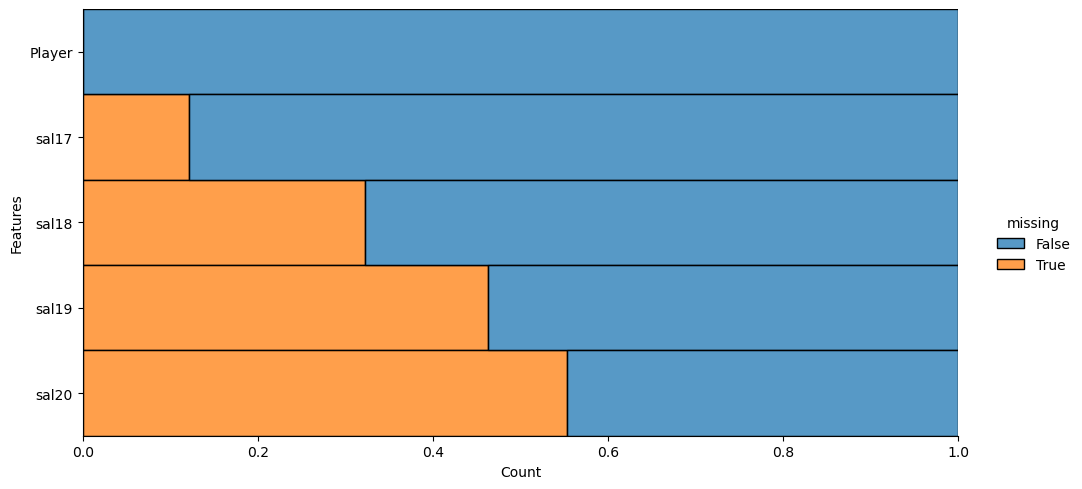

In [126]:
#sal18, sal19 and sal20 exceed threshold for Imputing as a Feature.
#As targets they are wholly unacceptable. Hopefully, sal17 missings can be Imputed
#from sal 18 values without worsening results.
plt.figure(figsize=(14,16))
graph = sns.displot(data=df2sal.isna().melt(value_name='missing'), y='variable', hue='missing', aspect=2.0, multiple='fill')
graph.set(ylabel='Features');

In [127]:
df[df.isna().any(axis=1)]

,Player,Nation,Pos,Squad,Comp,Age,MP,Starts,Min,90s,...,npxG+xAG,xG.1,xAG.1,xG+xAG,npxG.1,npxG+xAG.1,sal17,sal18,sal19,sal20
1,Ignazio Abate,it ITA,DF,Milan,it Serie A,30.0,17,11,1057,11.7,...,0.7,0.01,0.04,0.06,0.01,0.06,3795733.0,3835357.0,NaN,NaN
2,Aymen Abdennour,tn TUN,DF,Marseille,fr Ligue 1,27.0,8,6,499,5.5,...,0.1,0.02,0.00,0.02,0.02,0.02,4460325.0,0.0,NaN,NaN
3,Aly Abeid,mr MTN,DF,Levante,es La Liga,19.0,1,1,77,0.9,...,0.1,0.00,0.08,0.08,0.00,0.08,0.0,NaN,NaN,NaN
4,Mehdi Abeid,dz ALG,MF,Dijon,fr Ligue 1,24.0,19,14,1176,13.1,...,1.3,0.07,0.02,0.10,0.07,0.10,426851.0,430453.0,432254.0,NaN
5,David Abraham,ar ARG,DF,Eint Frankfurt,de Bundesliga,31.0,27,27,2302,25.6,...,1.1,0.01,0.03,0.04,0.01,0.04,1249035.0,1260742.0,1260742.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424,Ervin Zukanović,ba BIH,DF,Genoa,it Serie A,30.0,31,31,2873,31.9,...,3.2,0.05,0.05,0.10,0.05,0.10,NaN,NaN,NaN,NaN
2425,Robert Žulj,at AUT,MFFW,Hoffenheim,de Bundesliga,25.0,5,1,208,2.3,...,1.0,0.36,0.08,0.44,0.36,0.44,NaN,NaN,NaN,NaN
2426,Bongani Zungu,za RSA,MF,Amiens,fr Ligue 1,24.0,26,24,2084,23.2,...,0.6,0.01,0.02,0.02,0.01,0.02,266556.0,269258.0,648381.0,NaN
2427,David Zurutuza,es ESP,MF,Real Sociedad,es La Liga,31.0,31,26,2242,24.9,...,3.2,0.08,0.05,0.13,0.08,0.13,711418.0,717722.0,720424.0,NaN


<Figure size 1400x1600 with 0 Axes>

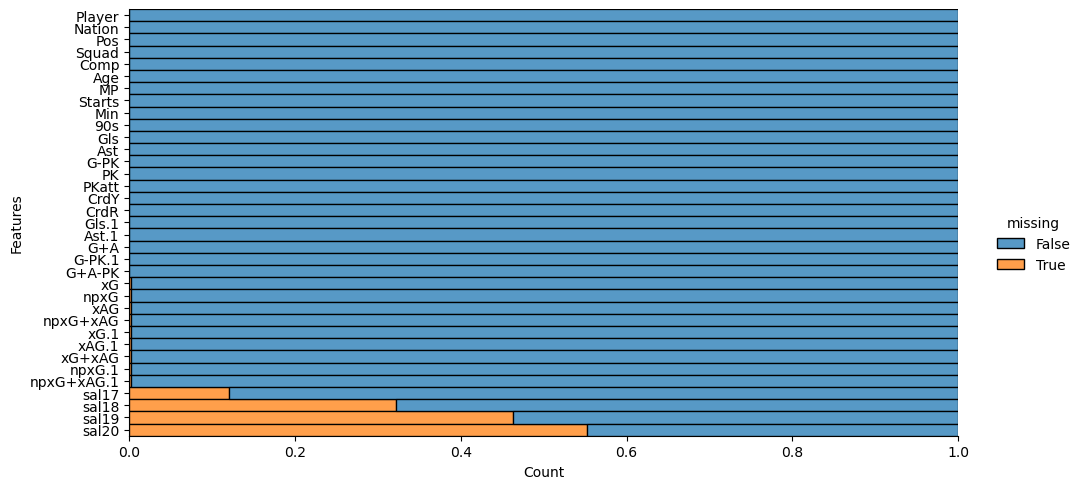

In [128]:
plt.figure(figsize=(14,16))
graph = sns.displot(data=df.isna().melt(value_name='missing'), y='variable',hue='missing',aspect=2.0,multiple='fill')
graph.set(ylabel='Features');

### Dataframe 3: Advanced GK stats <a id="subparagraph3"></a>
Midseason transfers will be treated same as in Dataframe 1.

https://fbref.com/en/comps/Big5/2017-2018/keepersadv/players/2017-2018-Big-5-European-Leagues-Stats

In [129]:
df3 = pd.read_csv("../data/raw/fut2017advgk.txt", header=1)
df3.head(3)

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,90s,GA,...,Launch%.1,AvgLen.1,Opp,Stp,Stp%,#OPA,#OPA/90,AvgDist,Matches,-9999
0,1,Antonio Adán,es ESP,GK,Betis,es La Liga,30,1987,30.0,53.0,...,59.7,44.4,468.0,17.0,3.6,22.0,0.73,14.6,Matches,65d62814
1,2,René Adler,de GER,GK,Mainz 05,de Bundesliga,32,1985,14.0,18.0,...,76.9,54.9,209.0,19.0,9.1,22.0,1.57,15.4,Matches,f71890f5
2,3,Adrián,es ESP,GK,West Ham,eng Premier League,30,1987,19.0,29.0,...,90.2,59.3,316.0,13.0,4.1,31.0,1.63,16.0,Matches,f76e6b4e


<Figure size 1400x1600 with 0 Axes>

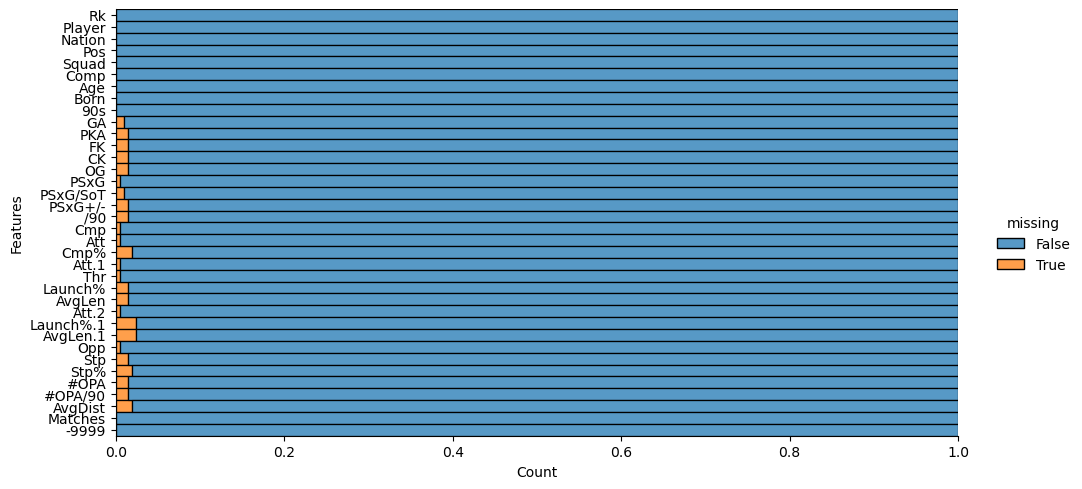

In [130]:
plt.figure(figsize=(14,16))
graph = sns.displot(data=df3.isna().melt(value_name='missing'), y='variable',hue='missing',aspect=2.0,multiple='fill')
graph.set(ylabel='Features');

In [131]:
advgkcols_to_use = df3.columns.difference(df.columns)
advgkcols_to_use = list(advgkcols_to_use.to_list())
advgkcols_to_use.append('Player')
df = pd.merge(df, df3[advgkcols_to_use], on='Player', how='left')
len(df)

2429

<Figure size 1600x1600 with 0 Axes>

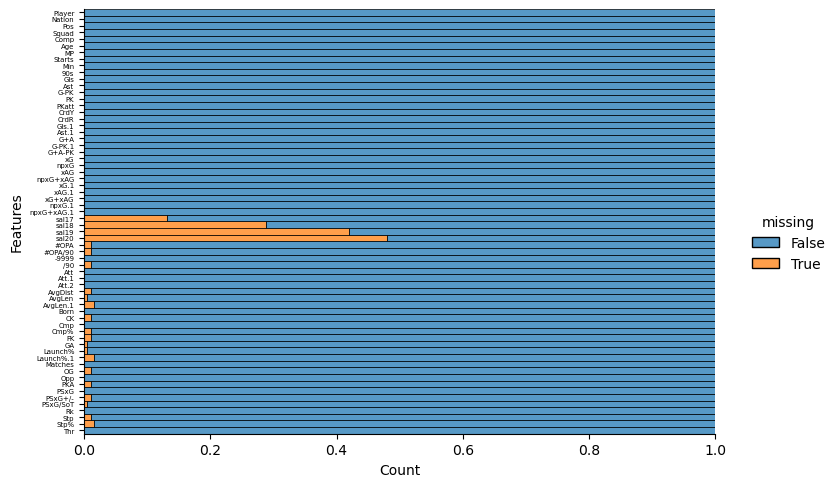

In [132]:
plt.figure(figsize=(16,16))
graph = sns.displot(data=df.loc[df['Pos']=='GK'].isna().melt(value_name='missing'), y='variable', hue='missing', aspect=1.6, multiple='fill')
graph.set_ylabels('Features', fontsize=10)
graph.set_yticklabels(fontsize=5);

In [133]:
del advgkcols_to_use[-1]
for col in advgkcols_to_use:
    df[col].fillna(value=0, inplace=True)
df.loc[df['Pos']!='GK'][['Player','Launch%']][:5]

,Player,Launch%
0,Patrick van Aanholt,0.0
1,Ignazio Abate,0.0
2,Aymen Abdennour,0.0
3,Aly Abeid,0.0
4,Mehdi Abeid,0.0


### Dataframe 4: Goal and Shot Creation Stats <a id="subparagraph4"></a>
Midseason transfers will be treated same as in Dataframe 1.

https://fbref.com/en/comps/Big5/2017-2018/gca/players/2017-2018-Big-5-European-Leagues-Stats

In [134]:
df4 = pd.read_csv("../data/raw/fut2017advgoalandshot.txt", header=1)
df4.head(3)

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,90s,Att,...,TI,CK,In,Out,Str,Cmp,Off,Blocks,Matches,-9999
0,1,Patrick van Aanholt,nl NED,DF,Crystal Palace,eng Premier League,26.0,1990.0,24.3,1176.0,...,235.0,11.0,3.0,5.0,2.0,884.0,3.0,31.0,Matches,5f09991f
1,2,Rolando Aarons,eng ENG,MFFW,Newcastle Utd,eng Premier League,21.0,1995.0,1.5,44.0,...,0.0,0.0,0.0,0.0,0.0,29.0,1.0,3.0,Matches,c5942695
2,3,Rolando Aarons,eng ENG,MFFW,Hellas Verona,it Serie A,21.0,1995.0,5.7,120.0,...,4.0,0.0,0.0,0.0,0.0,87.0,0.0,5.0,Matches,c5942695


<Figure size 1400x1600 with 0 Axes>

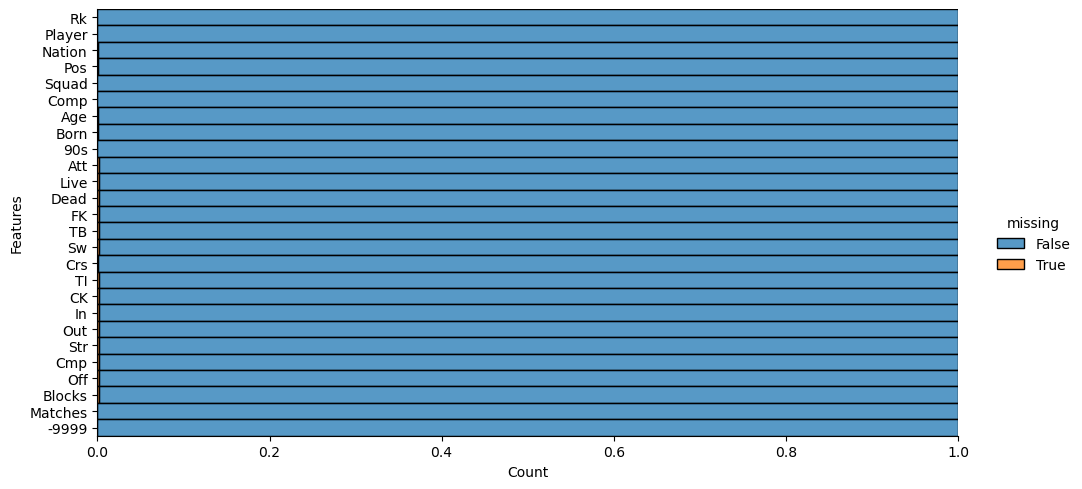

In [135]:
plt.figure(figsize=(14,16))
graph = sns.displot(data=df4.isna().melt(value_name='missing'), y='variable',hue='missing',aspect=2.0,multiple='fill')
graph.set(ylabel='Features');

In [136]:
df4.drop(columns=['Born', 'Age', 'Pos', 'Nation'], axis=1, inplace=True)

In [137]:
cols_to_use = df4.columns.difference(df.columns)
cols_to_use = list(cols_to_use.to_list())
cols_to_use.append('Player')
df = pd.merge(df, df4[cols_to_use], on='Player', how='left')
len(df)

2429

### Dataframe 5: Pass Type <a id="subparagraph5"></a>
Midseason transfers will be treated same as in Dataframe 1.

https://fbref.com/en/comps/Big5/2017-2018/passing_types/players/2017-2018-Big-5-European-Leagues-Stats

In [138]:
df5 = pd.read_csv("../data/raw/fut2017advpass.txt", header=1)
df5.head(3)

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,90s,Att,...,TI,CK,In,Out,Str,Cmp,Off,Blocks,Matches,-9999
0,1,Patrick van Aanholt,nl NED,DF,Crystal Palace,eng Premier League,26.0,1990.0,24.3,1176.0,...,235.0,11.0,3.0,5.0,2.0,884.0,3.0,31.0,Matches,5f09991f
1,2,Rolando Aarons,eng ENG,MFFW,Newcastle Utd,eng Premier League,21.0,1995.0,1.5,44.0,...,0.0,0.0,0.0,0.0,0.0,29.0,1.0,3.0,Matches,c5942695
2,3,Rolando Aarons,eng ENG,MFFW,Hellas Verona,it Serie A,21.0,1995.0,5.7,120.0,...,4.0,0.0,0.0,0.0,0.0,87.0,0.0,5.0,Matches,c5942695


<Figure size 1400x1600 with 0 Axes>

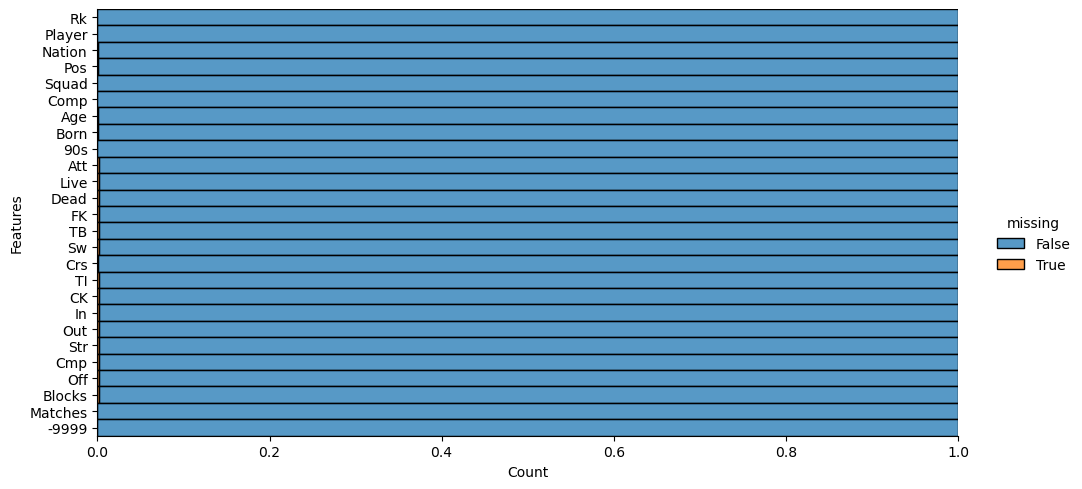

In [139]:
plt.figure(figsize=(14,16))
graph = sns.displot(data=df5.isna().melt(value_name='missing'), y='variable',hue='missing',aspect=2.0,multiple='fill')
graph.set(ylabel='Features');

In [140]:
cols_to_use = df5.columns.difference(df.columns)
cols_to_use = list(cols_to_use.to_list())
cols_to_use.append('Player')
df = pd.merge(df, df5[cols_to_use], on='Player', how='left')
len(df)

2429

### Dataframe 6: Shooting Stats <a id="subparagraph6"></a>
Midseason transfers will be treated same as in Dataframe 1.

https://fbref.com/en/comps/Big5/2017-2018/shooting/players/2017-2018-Big-5-European-Leagues-Stats

In [141]:
df6 = pd.read_csv("../data/raw/fut2017shooting.txt", header=1)
df6.head(3)

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,90s,Gls,...,FK,PK,PKatt,xG,npxG,npxG/Sh,G-xG,np:G-xG,Matches,-9999
0,1,Patrick van Aanholt,nl NED,DF,Crystal Palace,eng Premier League,26.0,1990.0,24.3,5,...,4.0,0,0,3.1,3.1,0.09,1.9,1.9,Matches,5f09991f
1,2,Rolando Aarons,eng ENG,MFFW,Newcastle Utd,eng Premier League,21.0,1995.0,1.5,0,...,0.0,0,0,0.1,0.1,0.03,-0.1,-0.1,Matches,c5942695
2,3,Rolando Aarons,eng ENG,MFFW,Hellas Verona,it Serie A,21.0,1995.0,5.7,0,...,0.0,0,0,0.2,0.2,0.05,-0.2,-0.2,Matches,c5942695


<Figure size 1400x1600 with 0 Axes>

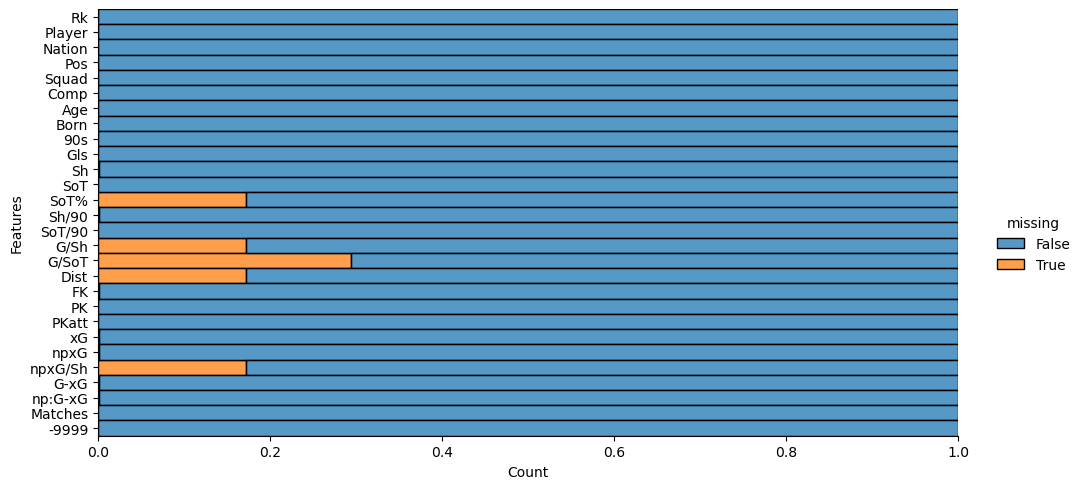

In [142]:
plt.figure(figsize=(14,16))
graph = sns.displot(data=df6.isna().melt(value_name='missing'), y='variable', hue='missing', aspect=2.0, multiple='fill')
graph.set(ylabel='Features');

In [143]:
df6.drop(axis=1, columns=['G/SoT', 'npxG/Sh', 'Dist', 'G/Sh', 'SoT%'], inplace=True)
df6.drop(axis=1, columns=['Nation', 'Born', 'Age', 'Pos'], inplace=True)

In [144]:
cols_to_use = df6.columns.difference(df.columns)
cols_to_use = list(cols_to_use.to_list())
cols_to_use.append('Player')
df = pd.merge(df, df6[cols_to_use], on='Player', how='left')
len(df)

2429

### Dataframe 7: Defensive Action Stats <a id="subparagraph7"></a>
Midseason transfers will be treated same as in Dataframe 1.

https://fbref.com/en/comps/Big5/2017-2018/defense/players/2017-2018-Big-5-European-Leagues-Stats

In [145]:
df7 = pd.read_csv("../data/raw/fut2017defact.txt", header=1)
df7.head(5)

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,90s,Att,...,TI,CK,In,Out,Str,Cmp,Off,Blocks,Matches,-9999
0,1,Patrick van Aanholt,nl NED,DF,Crystal Palace,eng Premier League,26.0,1990.0,24.3,1176.0,...,235.0,11.0,3.0,5.0,2.0,884.0,3.0,31.0,Matches,5f09991f
1,2,Rolando Aarons,eng ENG,MFFW,Newcastle Utd,eng Premier League,21.0,1995.0,1.5,44.0,...,0.0,0.0,0.0,0.0,0.0,29.0,1.0,3.0,Matches,c5942695
2,3,Rolando Aarons,eng ENG,MFFW,Hellas Verona,it Serie A,21.0,1995.0,5.7,120.0,...,4.0,0.0,0.0,0.0,0.0,87.0,0.0,5.0,Matches,c5942695
3,4,Ignazio Abate,it ITA,DF,Milan,it Serie A,30.0,1986.0,11.7,776.0,...,112.0,0.0,0.0,0.0,0.0,625.0,4.0,21.0,Matches,1c529186
4,5,Aymen Abdennour,tn TUN,DF,Marseille,fr Ligue 1,27.0,1989.0,5.5,333.0,...,0.0,0.0,0.0,0.0,0.0,310.0,1.0,2.0,Matches,2f798b41


<Figure size 1400x1600 with 0 Axes>

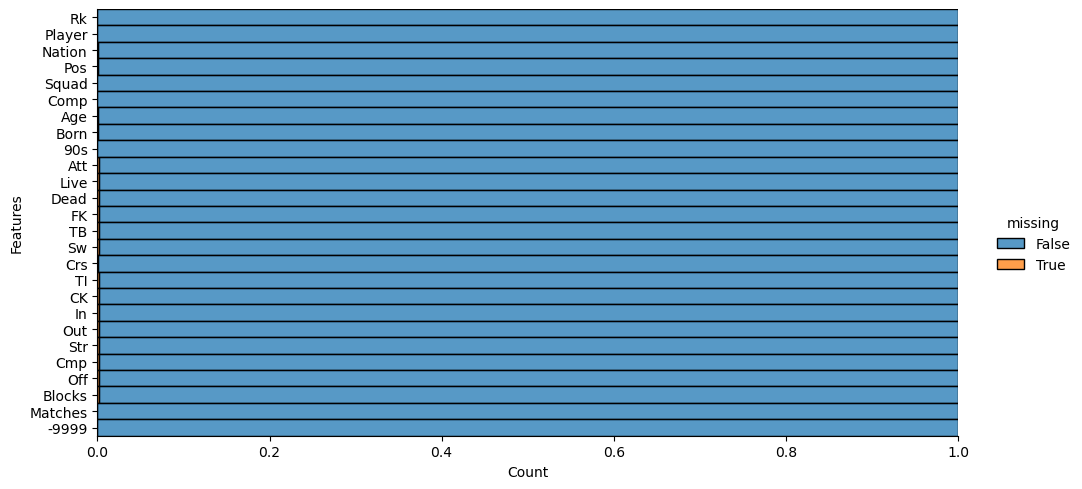

In [146]:
plt.figure(figsize=(14,16))
graph = sns.displot(data=df7.isna().melt(value_name='missing'), y='variable', hue='missing', aspect=2.0, multiple='fill')
graph.set(ylabel='Features');

In [147]:
cols_to_use = df7.columns.difference(df.columns)
cols_to_use = list(cols_to_use.to_list())
cols_to_use.append('Player')
df = pd.merge(df, df7[cols_to_use], on='Player', how='left')
len(df)

2429

### Dataframe 8: Goalkeeper Stats <a id="subparagraph8"></a>
Midseason transfers will be treated same as in Dataframe 1.

https://fbref.com/en/comps/Big5/2017-2018/keepers/players/2017-2018-Big-5-European-Leagues-Stats

In [148]:
df8 = pd.read_csv("../data/raw/fut2017gk.txt", header=1)
df8.head(3)

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,L,CS,CS%,PKatt,PKA,PKsv,PKm,Save%.1,Matches,-9999
0,1,Antonio Adán,es ESP,GK,Betis,es La Liga,30,1987,30,30,...,12.0,9.0,30.0,4.0,3.0,1.0,0.0,25.0,Matches,65d62814
1,2,René Adler,de GER,GK,Mainz 05,de Bundesliga,32,1985,14,14,...,6.0,4.0,28.6,2.0,1.0,0.0,1.0,0.0,Matches,f71890f5
2,3,Adrián,es ESP,GK,West Ham,eng Premier League,30,1987,19,19,...,6.0,6.0,31.6,1.0,1.0,0.0,0.0,0.0,Matches,f76e6b4e


<Figure size 1400x1600 with 0 Axes>

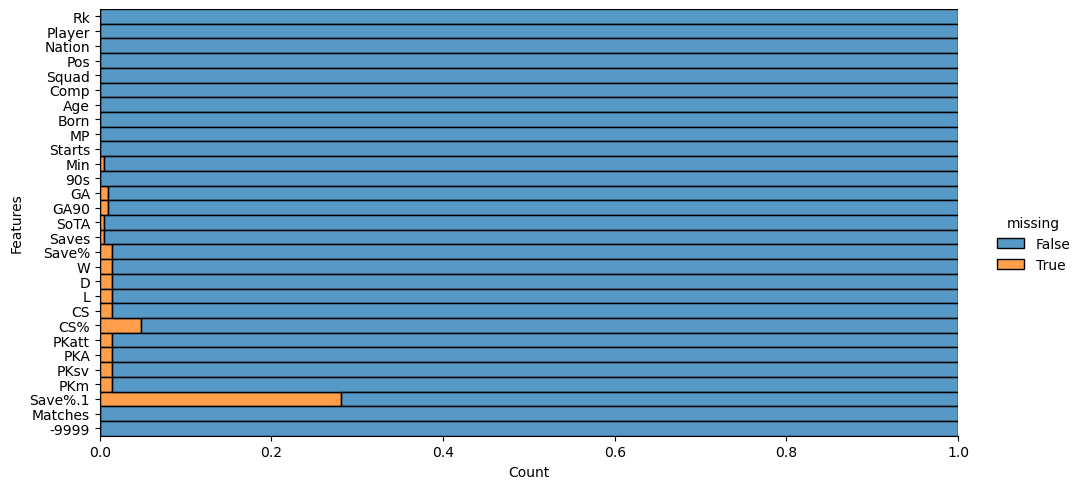

In [149]:
plt.figure(figsize=(14,16))
graph = sns.displot(data=df8.isna().melt(value_name='missing'), y='variable', hue='missing', aspect=2.0, multiple='fill')
graph.set(ylabel='Features');

In [150]:
df8.drop(axis=1, columns='Save%.1', inplace=True)

In [151]:
gkcols_to_use = df8.columns.difference(df.columns)
gkcols_to_use = list(gkcols_to_use.to_list())
gkcols_to_use.append('Player')
df = pd.merge(df, df8[gkcols_to_use], on='Player', how='left')
len(df)

2429

In [152]:
del gkcols_to_use[-1]
for col in gkcols_to_use:
    df[col].fillna(value=0, inplace=True)

### Dataframe 9: Miscelleanous Stats <a id="subparagraph9"></a>
Midseason transfers will be treated same as in Dataframe 1.

https://fbref.com/en/comps/Big5/2017-2018/misc/players/2017-2018-Big-5-European-Leagues-Stats

In [153]:
df9 = pd.read_csv("../data/raw/fut2017miscstats.txt", header=1)
df9.head(3)

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,90s,CrdY,...,TklW,PKwon,PKcon,OG,Recov,Won,Lost,Won%,Matches,-9999
0,1,Patrick van Aanholt,nl NED,DF,Crystal Palace,eng Premier League,26.0,1990.0,24.3,7,...,32.0,0.0,0.0,0.0,162.0,6.0,5.0,54.5,Matches,5f09991f
1,2,Rolando Aarons,eng ENG,MFFW,Newcastle Utd,eng Premier League,21.0,1995.0,1.5,0,...,4.0,0.0,0.0,0.0,9.0,1.0,3.0,25.0,Matches,c5942695
2,3,Rolando Aarons,eng ENG,MFFW,Hellas Verona,it Serie A,21.0,1995.0,5.7,0,...,8.0,0.0,0.0,0.0,19.0,9.0,15.0,37.5,Matches,c5942695


<Figure size 1400x1600 with 0 Axes>

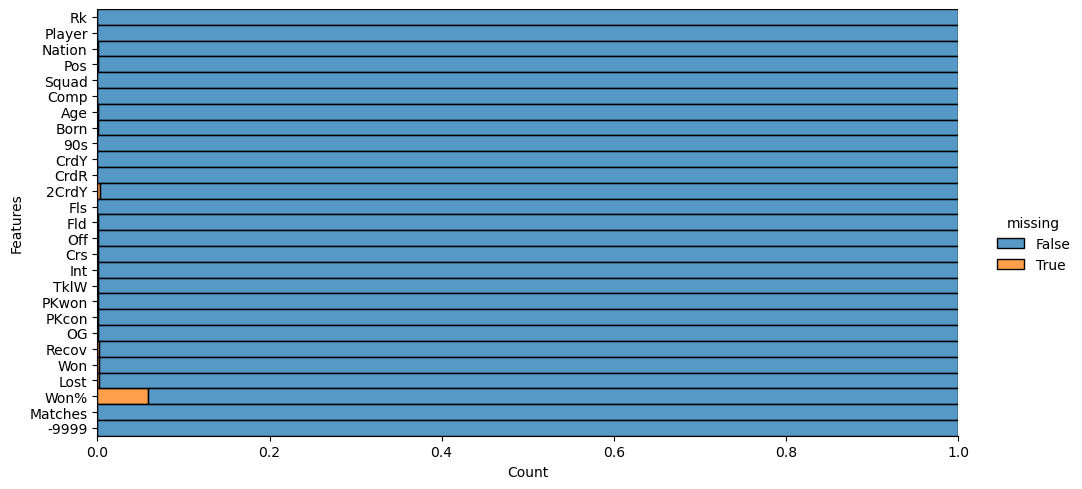

In [154]:
plt.figure(figsize=(14,16))
graph = sns.displot(data=df9.isna().melt(value_name='missing'), y='variable', hue='missing', aspect=2.0, multiple='fill')
graph.set(ylabel='Features');

In [155]:
df9.drop(axis=1, columns=['Born', 'Nation', 'Age', 'Pos'], inplace=True)

In [156]:
cols_to_use = df9.columns.difference(df.columns)
cols_to_use = list(cols_to_use.to_list())
cols_to_use.append('Player')
df = pd.merge(df, df9[cols_to_use], on='Player', how='left')
len(df)

2429

### Dataframe 10: Passing Stats <a id="subparagraph10"></a>
Midseason transfers will be treated same as in Dataframe 1.

https://fbref.com/en/comps/Big5/2017-2018/passing/players/2017-2018-Big-5-European-Leagues-Stats

In [157]:
df10 = pd.read_csv("../data/raw/fut2017passing.txt", header=1)
df10.head(3)

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,90s,Gls,...,FK,PK,PKatt,xG,npxG,npxG/Sh,G-xG,np:G-xG,Matches,-9999
0,1,Patrick van Aanholt,nl NED,DF,Crystal Palace,eng Premier League,26.0,1990.0,24.3,5,...,4.0,0,0,3.1,3.1,0.09,1.9,1.9,Matches,5f09991f
1,2,Rolando Aarons,eng ENG,MFFW,Newcastle Utd,eng Premier League,21.0,1995.0,1.5,0,...,0.0,0,0,0.1,0.1,0.03,-0.1,-0.1,Matches,c5942695
2,3,Rolando Aarons,eng ENG,MFFW,Hellas Verona,it Serie A,21.0,1995.0,5.7,0,...,0.0,0,0,0.2,0.2,0.05,-0.2,-0.2,Matches,c5942695


<Figure size 1400x1600 with 0 Axes>

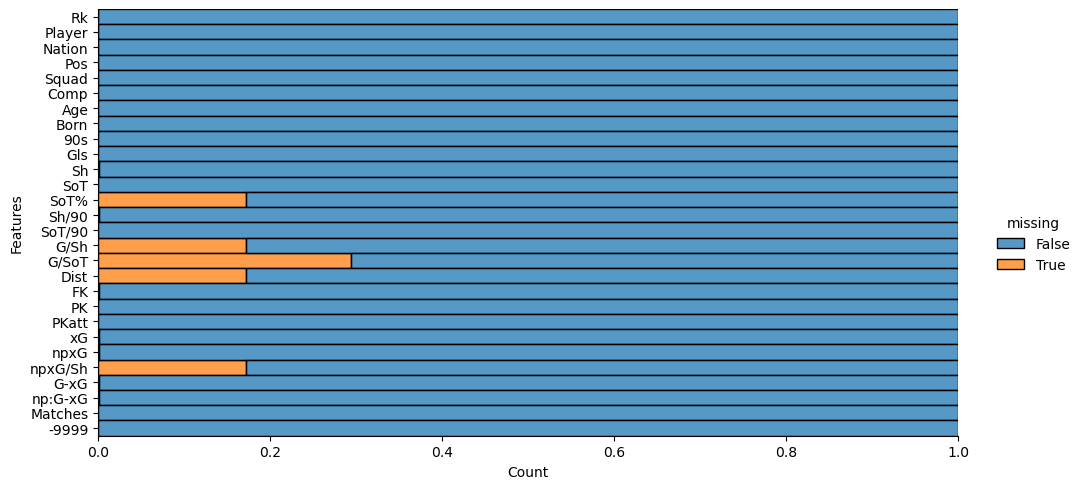

In [158]:
plt.figure(figsize=(14,16))
graph = sns.displot(data=df10.isna().melt(value_name='missing'), y='variable',hue='missing',aspect=2.0,multiple='fill')
graph.set(ylabel='Features');

In [159]:
df10.drop(axis=1, columns='G/SoT', inplace=True)
df10.drop(axis=1, columns=['Born', 'Nation', 'Age', 'Pos'], inplace=True)

In [160]:
cols_to_use = df10.columns.difference(df.columns)
cols_to_use = list(cols_to_use.to_list())
cols_to_use.append('Player')
df = pd.merge(df, df10[cols_to_use], on='Player', how='left')
len(df)

2429

### Dataframe 11: Playtime Stats <a id="subparagraph11"></a>
Midseason transfers will be treated same as in Dataframe 1.

https://fbref.com/en/comps/Big5/2017-2018/playingtime/players/2017-2018-Big-5-European-Leagues-Stats

In [161]:
df11 = pd.read_csv("../data/raw/fut2017playtime.txt", header=1)
df11.head(3)

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Min,...,+/-,+/-90,On-Off,onxG,onxGA,xG+/-,xG+/-90,On-Off.1,Matches,-9999
0,1,Ismael Aaneba,fr FRA,DF,Strasbourg,fr Ligue 1,18.0,1999.0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Matches,a7e4760c
1,2,Patrick van Aanholt,nl NED,DF,Crystal Palace,eng Premier League,26.0,1990.0,28,2184.0,...,-7.0,-0.29,-0.07,32.2,34.7,-2.5,-0.10,-0.66,Matches,5f09991f
2,3,Rolando Aarons,eng ENG,MFFW,Newcastle Utd,eng Premier League,21.0,1995.0,4,139.0,...,-1.0,-0.65,-0.46,0.4,2.9,-2.6,-1.66,-1.43,Matches,c5942695


<Figure size 1400x1600 with 0 Axes>

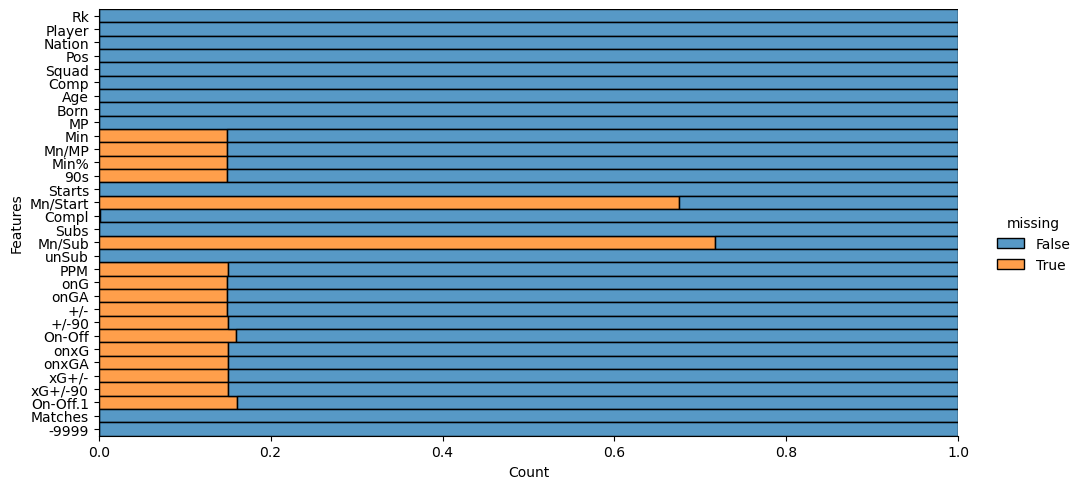

In [162]:
plt.figure(figsize=(14,16))
graph = sns.displot(data=df11.isna().melt(value_name='missing'), y='variable', hue='missing', aspect=2.0, multiple='fill')
graph.set(ylabel='Features');

In [163]:
df11.drop(axis=1, columns=['Mn/Start', 'Mn/Sub'], inplace=True)
df11.drop(axis=1, columns=['Born', 'Nation', 'Age', 'Pos'], inplace=True)

In [164]:
df11.drop_duplicates(subset='Player', inplace=True)

In [165]:
cols_to_use = df11.columns.difference(df.columns)
cols_to_use = list(cols_to_use.to_list())
cols_to_use.append('Player')
df = pd.merge(df, df11[cols_to_use], on='Player', how='left')
len(df)

2429

### Dataframe 12: Possession Stats <a id="subparagraph12"></a>
Midseason transfers will be treated same as in Dataframe 1.

https://fbref.com/en/comps/Big5/2017-2018/possession/players/2017-2018-Big-5-European-Leagues-Stats

In [166]:
df12 = pd.read_csv("../data/raw/fut2017poss.txt", header=1)
df12.head(3)

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,90s,Att,...,TI,CK,In,Out,Str,Cmp,Off,Blocks,Matches,-9999
0,1,Patrick van Aanholt,nl NED,DF,Crystal Palace,eng Premier League,26.0,1990.0,24.3,1176.0,...,235.0,11.0,3.0,5.0,2.0,884.0,3.0,31.0,Matches,5f09991f
1,2,Rolando Aarons,eng ENG,MFFW,Newcastle Utd,eng Premier League,21.0,1995.0,1.5,44.0,...,0.0,0.0,0.0,0.0,0.0,29.0,1.0,3.0,Matches,c5942695
2,3,Rolando Aarons,eng ENG,MFFW,Hellas Verona,it Serie A,21.0,1995.0,5.7,120.0,...,4.0,0.0,0.0,0.0,0.0,87.0,0.0,5.0,Matches,c5942695


<Figure size 1400x1600 with 0 Axes>

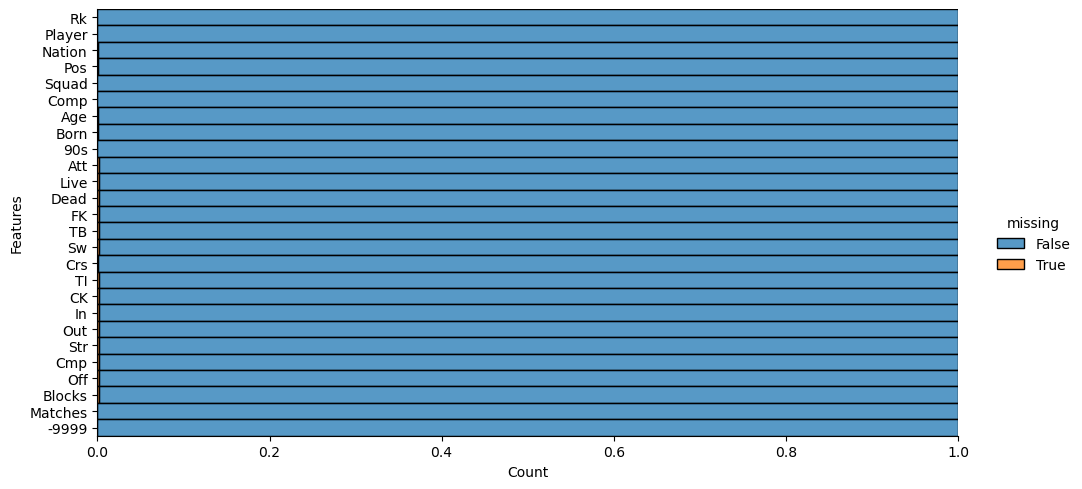

In [167]:
plt.figure(figsize=(14,16))
graph = sns.displot(data=df12.isna().melt(value_name='missing'), y='variable', hue='missing', aspect=2.0, multiple='fill')
graph.set(ylabel='Features');

In [168]:
cols_to_use = df12.columns.difference(df.columns)
cols_to_use = list(cols_to_use.to_list())
cols_to_use.append('Player')
df = pd.merge(df, df12[cols_to_use], on='Player', how='left')
len(df)

2429

### Dataframe 13: Team Wages <a id="subparagraph13"></a>
Midseason transfers will be treated same as in Dataframe 1.

Team Wage as feature is too directly linked to target. Will bin this feature.

https://fbref.com/en/comps/Big5/2017-2018/wages/2017-2018-Big-5-European-Leagues-Wages

In [169]:
df13 = pd.read_csv("../data/raw/fut2017teamwages.txt")
df13.head(3)

,Rk,Squad,Comp,# Pl,Weekly Wages,Annual Wages,% Estimated
0,1,Barcelona,es La Liga,33,€ 4682115 (£ 3925993 $4771599),€ 243470000 (£ 204151634 $248123125),100%
1,2,Real Madrid,es La Liga,32,€ 3949904 (£ 3312027 $4025393),€ 205395000 (£ 172225426 $209320446),100%
2,3,Paris S-G,fr Ligue 1,35,€ 3895462 (£ 3266377 $3969910),€ 202564000 (£ 169851608 $206435344),100%


In [170]:
#GDP as Annual Player Salaries are expressed in that currency
df13['Annual Wages'] = [i.split(" ")[3] for i in df13['Annual Wages']]

In [171]:
teamwages = {
    df13['Squad'][i]: df13['Annual Wages'][i] for i in range(len(df13))
}

In [172]:
teamwage = [teamwages.get(squad) for squad in df['Squad']]
df['TeamWage'] = teamwage

In [173]:
df[df['TeamWage'].isnull()][:4]

,Player,Nation,Pos,Squad,Comp,Age,MP,Starts,Min,90s,...,PPM,Subs,onG,onGA,onxG,onxGA,unSub,xG+/-,xG+/-90,TeamWage
43,Miiko Albornoz,cl CHI,DFMF,Hannover 96,de Bundesliga,26.0,10,7,703,7.8,...,0.70,3,10.0,17.0,10.1,14.5,10,-4.4,-0.57,None
53,Alexander,ar ARG,MFFW,Leganés,es La Liga,28.0,13,13,1060,11.8,...,1.31,0,8.0,12.0,13.8,14.7,0,-0.9,-0.08,None
79,Jon Ander Serantes,es ESP,GK,Leganés,es La Liga,27.0,1,1,90,1.0,...,3.00,0,3.0,2.0,1.4,2.2,2,-0.8,-0.77,None
87,Miguel Ángel Guerrero,es ESP,FW,Leganés,es La Liga,27.0,22,15,1442,16.0,...,1.05,7,17.0,24.0,16.4,23.1,2,-6.7,-0.42,None


In [174]:
df[df['Squad'] == 'Hannover 96'].groupby(by=['Squad'])['sal17'].sum()

Squad
Hannover 96    22875252.0
Name: sal17, dtype: float64

In [175]:
df.loc[df['Squad'] == 'Hannover 96', 'TeamWage'] = str(32388451.0)

In [176]:
df[df['Squad'] == 'Leganés'].groupby(by=['Squad'])['sal17'].sum()

Squad
Leganés    8789166.0
Name: sal17, dtype: float64

In [177]:
df.loc[df['Squad'] == 'Leganés', 'TeamWage'] = str(10847290.0)

## EDA of Combined Dataframe <a id="paragraph3"></a>
Time to deal with NaNs, nulls, objects, cardinality, etc.

In [178]:
df.describe(include=['object'])

,Player,Nation,Pos,Squad,Comp,-9999,Matches,TeamWage
count,2429,2429,2429,2429,2429,2429,2429,2429
unique,2429,107,10,98,5,201,2,98
top,Patrick van Aanholt,es ESP,DF,Benevento,es La Liga,0,0,14861727
freq,1,347,745,36,511,2229,2229,36


In [179]:
df.drop('Squad', axis=1, inplace=True)
df.drop('-9999', axis=1, inplace=True)
df.drop('Matches', axis=1, inplace=True)

### Nations: Fix NaN and Reduce Cardinality <a name="subparagraph2"></a>
One player was missing stats, oopulated with real data above. Top ten nations represented in big 5 kept. All others coded as OTHERS before One Hot Encoding. All instances of OHE will drop a column to mitigate risk of colinearity when modeling.

In [180]:
print(df['Nation'].values)
df.groupby('Nation')['Nation'].count().sort_values(ascending=False).head(10)

['nl NED' 'it ITA' 'tn TUN' ... 'za RSA' 'es ESP' 'es ESP']


Nation
es ESP     347
fr FRA     272
it ITA     245
de GER     217
eng ENG    166
ar ARG      93
br BRA      92
sn SEN      50
nl NED      44
be BEL      44
Name: Nation, dtype: int64

In [181]:
#Local players (ie from Big 5 home countries). Bool
localcountries = ['es ESP', 'fr FRA', 'it ITA', 'de GER', 'eng ENG']
df['local'] = df['Nation'].apply(lambda x: x in localcountries)
df['local'].value_counts()

True     1247
False    1182
Name: local, dtype: int64

In [182]:
df.drop('Nation', inplace=True, axis=1)

### Postions: Nulls, NaNs and OHE <a name="subparagraph3"></a> 
A closer look.

In [183]:
df['Pos'].unique()

array(['DF', 'MF', 'FW', 'GK', 'DFFW', 'DFMF', 'MFFW', 'FWMF', 'MFDF',
       'FWDF'], dtype=object)

In [184]:
df['Pos'].isnull().value_counts()

False    2429
Name: Pos, dtype: int64

In [185]:
df['Pos'].value_counts()

DF      745
MF      517
FW      299
FWMF    242
MFFW    239
GK      198
DFMF     82
MFDF     54
DFFW     36
FWDF     17
Name: Pos, dtype: int64

In [186]:
utilitydefender = ['DFMF', 'MFDF', 'DFFW', 'FWDF']
df['Pos'] = df['Pos'].apply(lambda x: 'UTIDEF' if x in utilitydefender else x)
df['Pos'].value_counts()

DF        745
MF        517
FW        299
FWMF      242
MFFW      239
GK        198
UTIDEF    189
Name: Pos, dtype: int64

In [187]:
utilityattacker = ['FWMF', 'MFFW']
df['Pos'] = df['Pos'].apply(lambda x: 'UTIATT' if x in utilityattacker else x)
df['Pos'].value_counts()

DF        745
MF        517
UTIATT    481
FW        299
GK        198
UTIDEF    189
Name: Pos, dtype: int64

In [188]:
onehotencoder = OneHotEncoder()
X = onehotencoder.fit_transform(df['Pos'].values.reshape(-1,1)).toarray()
dfOneHot = pd.DataFrame(X, columns=[f"Pos_{int(i)}" for i in range(6)])
df = pd.concat([df, dfOneHot], axis=1)
df = df.drop(['Pos'], axis=1)
print(df['Pos_0'].sum())
df.drop('Pos_0', axis=1, inplace=True)

745.0


### Comps: NaNs and OHE <a name="subparagraph5"></a> 

In [189]:
df['Comp'].isna().value_counts()

False    2429
Name: Comp, dtype: int64

In [190]:
df['Comp'].value_counts()

es La Liga            511
fr Ligue 1            506
it Serie A            492
eng Premier League    476
de Bundesliga         444
Name: Comp, dtype: int64

In [191]:
onehotencoder = OneHotEncoder()
X = onehotencoder.fit_transform(df['Comp'].values.reshape(-1,1)).toarray()
dfOneHot = pd.DataFrame(X, columns=[f"Comp_{int(i)}" for i in range(5)])
df = pd.concat([df, dfOneHot], axis=1)
df = df.drop(['Comp'], axis=1)
print(df['Comp_0'].sum())
df.drop('Comp_0', axis=1, inplace=True)

444.0


### TeamWage: Convert to Int and Encode <a name="subparagraph6"></a> 

In [192]:
df['TeamWage'] = df['TeamWage'].astype(float).astype(int)

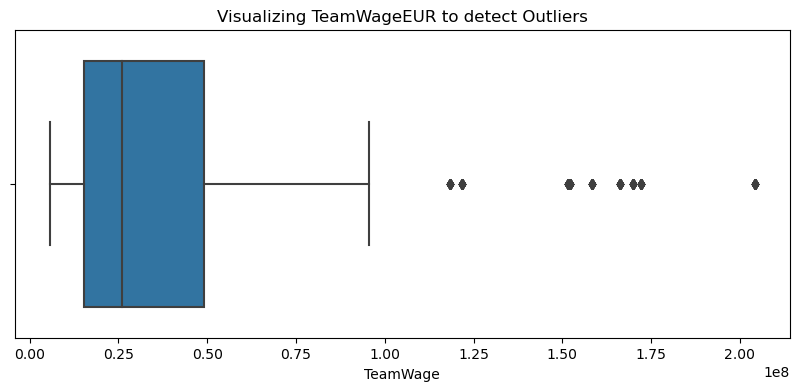

In [193]:
plt.figure(figsize=(10,4))
ax = sns.boxplot(df['TeamWage'])
ax.set_title('Visualizing TeamWageEUR to detect Outliers')
plt.show();

In [194]:
df['TeamWagebins'] = pd.qcut(df['TeamWage'], 6)

In [195]:
df["TeamWagebins"].value_counts()

(5760547.999, 12393992.0]    413
(18287868.0, 25945961.0]     408
(25945961.0, 42219000.0]     407
(12393992.0, 18287868.0]     403
(42219000.0, 68041000.0]     402
(68041000.0, 204151634.0]    396
Name: TeamWagebins, dtype: int64

In [196]:
df['TeamWagebins'] = le.fit_transform(df['TeamWagebins'])
df['TeamWagebins'].value_counts()

0    413
2    408
3    407
1    403
4    402
5    396
Name: TeamWagebins, dtype: int64

In [197]:
df.drop(columns="TeamWage", axis=1, inplace=True)

In [198]:
df.describe(include=['object'])

,Player
count,2429
unique,2429
top,Patrick van Aanholt
freq,1


In [199]:
df.drop(columns='TeamWagebins', axis=1, inplace=True)

In [200]:
df.to_csv('../data/processed/regclean.csv')

In [201]:
df.isna().sum().sort_values(ascending=False)[:10]

sal20       1343
sal19       1125
sal18        783
Dist         422
G/Sh         422
SoT%         422
npxG/Sh      422
sal17        294
Won%         136
On-Off.1      46
dtype: int64

## Baselines and Feature Intercorrelation <a id="paragraph4"></a>
Final review of database before creating models for the various hypothesis.

### Regressor Baseline <a id="subparagraph1"></a> 
With full df, simply dropping any target NaN values.

In [202]:
df = pd.read_csv('../data/processed/regclean.csv', index_col=0)

In [203]:
print(len(df))
df.dropna(subset='sal17', inplace=True)
df.reset_index(drop=True, inplace=True)
print(len(df))

df = df.loc[df['sal17'] != 0]
print(len(df))
df.drop(columns=['sal18', 'sal19', 'sal20'], inplace=True, axis=1)

2429
2135
1884


In [204]:
X = df.drop(['sal17', 'Player'], axis=1)
y = df["sal17"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

baseline_model = xgboost.XGBRegressor(random_state=42)

baseline_model.fit(X_train, y_train)

baseline_model.score(X_test, y_test)

0.4653064251071841

In [205]:
models_summary = pd.DataFrame(columns=["Target", "Model", "Score", "Notes"])

In [206]:
#Target untouched re imputation. All NaN and zero target values dropped. Other NaN values untouched.
save_results(baseline_model, "Baseline")
models_summary

,Target,Model,Score,Notes
0,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.465306,Baseline


In [207]:
y_pred = baseline_model.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

1376973.0503436783

In [208]:
df['sal17'].describe().round(2)

count        1884.00
mean      1829841.67
std       2638901.43
min          2701.00
25%        461971.00
50%       1040000.00
75%       2145062.00
max      35679899.00
Name: sal17, dtype: float64

Sal 17: Key Feature - npxG+xAG

Non-Penalty Expected Goals plus Assisted Goals
xG totals include penalty kicks, but do not include penalty shootouts

In [209]:
eli5.show_weights(baseline_model)

Weight,Feature
0.2175,npxG+xAG.1
0.1555,+/-
0.1483,xG+xAG
0.0795,Comp_1
0.0547,xG+/-
0.0258,Comp_2
0.0190,Sw
0.0155,In
0.0135,+/-90
0.0118,Compl


Imputing sal17 zeros with sal18 figures?

In [210]:
df = pd.read_csv('../data/processed/regclean.csv', index_col=0)

In [211]:
#df['<column_name>'] = np.where((<filter 1> ) & (<filter 2>) , <new value>, df['column_name'])
df['sal17'] = np.where(
    (df['sal17'] == 0) | (df['sal18'] > 0), 
    df['sal18'], 
    df['sal17']
    )

print(len(df))
df.dropna(subset='sal17', inplace=True)
df.reset_index(drop=True, inplace=True)
print(len(df))

df = df.loc[df['sal17'] != 0]
print(len(df))
df.drop(columns=['sal18', 'sal19', 'sal20'], inplace=True, axis=1)

#df.to_csv('../data/processed/reg20230102plus.csv')

2429
2021
1986


In [212]:
X = df.drop(['sal17', 'Player'], axis=1)
y = df["sal17"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

xgb_reg = xgboost.XGBRegressor(random_state=42)

xgb_reg.fit(X_train, y_train)

xgb_reg.score(X_test, y_test)

0.47759813253280803

In [213]:
df.to_csv('../data/processed/regcleanplus.csv')

In [214]:
#Baseline plus imputed target figures. Rest of NaN values untouched.
save_results(xgb_reg, 'BLP')
models_summary

,Target,Model,Score,Notes
0,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.465306,Baseline
1,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.477598,BLP


Feature Correlations

In [215]:
X.shape

(1986, 122)

In [216]:
#Example of how we are going to make correlation cuts
corr = X.corr()
c1 = corr.abs().unstack()
c1.sort_values(ascending=True, inplace=True)
columns_above_95 = [(col1, col2) for col1, col2 in c1.index if c1[col1,col2] > 0.95 and col1 != col2]
print(len(columns_above_95)/2)
columns_above_95[:8:2]

80.0


[('Save%', 'Cmp%'), ('Att', 'L'), ('AvgLen.1', 'Save%'), ('Save%', 'AvgDist')]

In [217]:
cor_matrix = X.corr().abs()

In [218]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))

In [219]:
to_drop90 = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
to_drop91 = [column for column in upper_tri.columns if any(upper_tri[column] > 0.91)]
to_drop92 = [column for column in upper_tri.columns if any(upper_tri[column] > 0.92)]
to_drop93 = [column for column in upper_tri.columns if any(upper_tri[column] > 0.93)]
to_drop94 = [column for column in upper_tri.columns if any(upper_tri[column] > 0.94)]
to_drop95 = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
to_drop96 = [column for column in upper_tri.columns if any(upper_tri[column] > 0.96)]
to_drop97 = [column for column in upper_tri.columns if any(upper_tri[column] > 0.97)]
to_drop98 = [column for column in upper_tri.columns if any(upper_tri[column] > 0.98)]
to_drop99 = [column for column in upper_tri.columns if any(upper_tri[column] > 0.99)]

X90 = X.drop(columns=to_drop90, axis=1)
X91 = X.drop(columns=to_drop91, axis=1)
X92 = X.drop(columns=to_drop92, axis=1)
X93 = X.drop(columns=to_drop93, axis=1)
X94 = X.drop(columns=to_drop94, axis=1)
X95 = X.drop(columns=to_drop95, axis=1)
X96 = X.drop(columns=to_drop96, axis=1)
X97 = X.drop(columns=to_drop97, axis=1)
X98 = X.drop(columns=to_drop98, axis=1)
X99 = X.drop(columns=to_drop99, axis=1)

In [220]:
X99.shape

(1986, 108)

In [221]:
X90.shape

(1986, 78)

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X90, y, test_size = 0.20, random_state = 42)
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
print(xgb_reg.score(X_test, y_test))

X_train, X_test, y_train, y_test = train_test_split(X91, y, test_size = 0.20, random_state = 42)
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
print(xgb_reg.score(X_test, y_test))

X_train, X_test, y_train, y_test = train_test_split(X92, y, test_size = 0.20, random_state = 42)
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
print(xgb_reg.score(X_test, y_test))

X_train, X_test, y_train, y_test = train_test_split(X93, y, test_size = 0.20, random_state = 42)
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
print(xgb_reg.score(X_test, y_test))

X_train, X_test, y_train, y_test = train_test_split(X94, y, test_size = 0.20, random_state = 42)
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
print(xgb_reg.score(X_test, y_test))

X_train, X_test, y_train, y_test = train_test_split(X95, y, test_size = 0.20, random_state = 42)
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
print(xgb_reg.score(X_test, y_test))

X_train, X_test, y_train, y_test = train_test_split(X96, y, test_size = 0.20, random_state = 42)
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
print(xgb_reg.score(X_test, y_test))

X_train, X_test, y_train, y_test = train_test_split(X97, y, test_size = 0.20, random_state = 42)
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
print(xgb_reg.score(X_test, y_test))

X_train, X_test, y_train, y_test = train_test_split(X98, y, test_size = 0.20, random_state = 42)
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
print(xgb_reg.score(X_test, y_test))

X_train, X_test, y_train, y_test = train_test_split(X99, y, test_size = 0.20, random_state = 42)
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
print(xgb_reg.score(X_test, y_test))

0.40217209955745825
0.42268044981731623
0.40662009989388126
0.4468089234544622
0.4090900078973908
0.42134172443308704
0.44017888814088213
0.4270319317501555
0.41538269738762845
0.4923813874818054


In [223]:
X_train, X_test, y_train, y_test = train_test_split(X99, y, test_size = 0.20, random_state = 42)
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
xgb_reg.score(X_test, y_test)
save_results(xgb_reg, "BLP FC99")

In [224]:
models_summary.sort_values(by='Score', ascending=False)

,Target,Model,Score,Notes
2,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.492381,BLP FC99
1,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.477598,BLP
0,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.465306,Baseline


In [225]:
df.drop(columns=to_drop99, inplace=True)

In [226]:
df.to_csv("../data/processed/fbREG_FC99.csv")

Fill NaN values with KNN Imputer: Compare with DropNaN

In [227]:
df = pd.read_csv("../data/processed/fbREG_FC99.csv", index_col=0)

In [228]:
X = df.drop(['sal17', 'Player'], axis=1)
y = df["sal17"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [229]:
cleanupDF(df)

In [230]:
X = df.drop(['sal17','Player'], axis=1)
y = df["sal17"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [231]:
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
KNN_NaNs = xgb_reg.score(X_test, y_test)

Drop NaNs?

In [232]:
df = pd.read_csv("../data/processed/fbREG_FC99.csv", index_col=0)
df.dropna(inplace=True)

In [233]:
X = df.drop(['sal17','Player'], axis=1)
y = df["sal17"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [234]:
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
DropNaNs = xgb_reg.score(X_test, y_test)

In [235]:
print('KNN score:', KNN_NaNs)
print('DropNaNs score:', DropNaNs)

KNN score: 0.4129680592269279
DropNaNs score: 0.4750691459409746


In [236]:
save_results(xgb_reg, "BLP FC99 DN")

In [237]:
models_summary.sort_values(by='Score', ascending=False)

,Target,Model,Score,Notes
2,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.492381,BLP FC99
1,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.477598,BLP
3,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.475069,BLP FC99 DN
0,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.465306,Baseline


In [238]:
df.to_csv("../data/processed/fbREG_FC99DN.csv")

PCA: on FC93 nN. Target has been log normalised due to strong left bias.

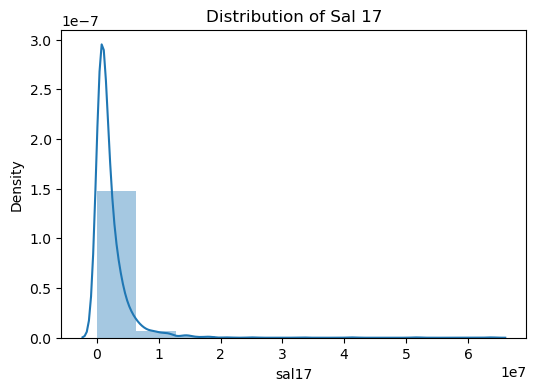

In [239]:
plt.figure(figsize=(6, 4))
temp = df['sal17']
x = pd.Series(temp, name='Sal 17')
ax = sns.distplot(temp, bins=10)
ax.set_title("Distribution of Sal 17")
plt.show();

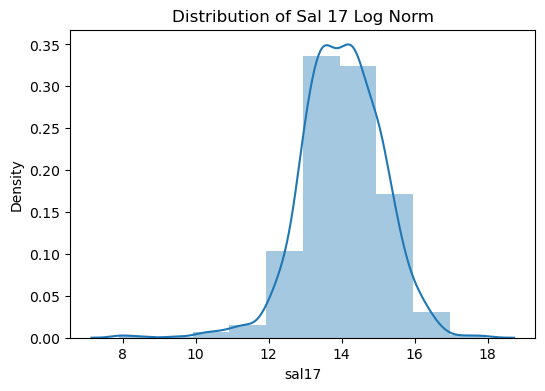

In [240]:
plt.figure(figsize=(6, 4))
temp = np.log1p(df['sal17'])
x = pd.Series(temp, name='Sal 17')
ax = sns.distplot(temp, bins=10)
ax.set_title("Distribution of Sal 17 Log Norm")
plt.show();

In [241]:
df = pd.read_csv("../data/processed/fbREG_FC99DN.csv", index_col=0)
X = df.drop(['sal17', 'Player'], axis=1)
y = np.log1p(df['sal17'])

In [242]:
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(data_rescaled, y, test_size = 0.20, random_state = 42)

params = {
    'pca__n_components': list(range(10, 64))
}

pipe = make_pipeline(MinMaxScaler(), PCA(), xgboost.XGBRegressor())
pipe

Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('pca', PCA()),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, enable_categorical=False,
                              gamma=None, gpu_id=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_delta_step=None, max_depth=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=None, reg_alpha=None,
                              reg_lambda=None, scale_pos_weight=None,
                              subsample=None, tree_method=None,
                              validate_parameters=None, verbosity=None))])

In [243]:
#gsearch = GridSearchCV(pipe, params, cv=10)
#gsearch.fit(X_train, y_train)

In [244]:
print("{'pca__n_components': 30}")
#gsearch.best_params_

{'pca__n_components': 30}


In [245]:
pca_reg = make_pipeline(MinMaxScaler(), PCA(n_components=30), xgboost.XGBRegressor())
pca_reg.fit(X_train, y_train)
print("Accuracy train", pca_reg.score(X_train, y_train))
print("Accuracy test", pca_reg.score(X_test, y_test))

Accuracy train 0.9977287546367596
Accuracy test 0.5223904381308265


In [246]:
models_summary.loc[len(models_summary.index)] = [
        'sal17',
        'XGBRegressor(pipe: MinMaxScaler, PCA(n=30), XGBRegressor)', 
        0.514210,
        'BLP PCA30 FC99DNYL']

In [247]:
models_summary.sort_values(by='Score', ascending=False)

,Target,Model,Score,Notes
4,sal17,"XGBRegressor(pipe: MinMaxScaler, PCA(n=30), XG...",0.514210,BLP PCA30 FC99DNYL
2,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.492381,BLP FC99
1,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.477598,BLP
3,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.475069,BLP FC99 DN
0,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.465306,Baseline


NORMALIZAR TARGETS

In [248]:
df = pd.read_csv("../data/processed/fbREG_FC99DN.csv", index_col=0)

X = df.drop(['sal17', 'Player'], axis=1)
y = np.log1p(df['sal17'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)


xgb_reg = xgboost.XGBRegressor(random_state=42)

xgb_reg.fit(X_train, y_train)
xgb_reg.score(X_test, y_test)

0.6572900360751082

In [249]:
save_results(xgb_reg, "BLP FC99DNYL")
models_summary.sort_values(by='Score', ascending=False)

,Target,Model,Score,Notes
5,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.657290,BLP FC99DNYL
4,sal17,"XGBRegressor(pipe: MinMaxScaler, PCA(n=30), XG...",0.514210,BLP PCA30 FC99DNYL
2,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.492381,BLP FC99
1,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.477598,BLP
3,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.475069,BLP FC99 DN
0,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.465306,Baseline


Decision Tree Regressor

In [250]:
tree_reg = DecisionTreeRegressor(max_depth=3,
                                  random_state=42)
tree_reg.fit(X_train, y_train)
tree_reg.score(X_test, y_test)

0.5145754547633888

In [251]:
save_results(tree_reg, "DT FC99DNYL")

Linear Regression

In [252]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_reg.score(X_test, y_test)

0.5436526349092263

In [253]:
save_results(lin_reg, 'LR FC99DNYL')

In [254]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

lr_lasso = LassoCV(alphas=arange(0, 1, 0.001), cv=cv, n_jobs=-1)

#lr_lasso.fit(X_train, y_train)

#print('alpha: %f' % lr_lasso.alpha_)
#lr_lasso.score(X_test, y_test)
print('alpha: 0.012')

alpha: 0.012


In [255]:
lr_lasso = Lasso(alpha=0.012)
lr_lasso.fit(X_train, y_train)
lr_lasso.score(X_test, y_test)

0.564220742371602

In [256]:
save_results(lr_lasso, 'LR FC99DNYL Lasso(0.012)')

In [257]:
param = {
    'alpha':[0.0001, 0.001, 0.01, 0.01, 1],
    'fit_intercept':[True, False],
    'normalize': [True, False],
    'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
       }

model = Ridge()

search = GridSearchCV(model, param, scoring='r2', n_jobs=-1, cv=cv)

#result = search.fit(X_train, y_train)

#print(f'Best Score: {result.best_score_}')
#print(f'Best Hyperparameters: {result.best_params_}')
print("alpha=0.0001, fit_intercept= True, normalize = True, solver ='sparse_cg'")

alpha=0.0001, fit_intercept= True, normalize = True, solver ='sparse_cg'


In [258]:
lr_ridge = Ridge(alpha=0.0001, fit_intercept= True, normalize = True, solver ='sparse_cg')
lr_ridge.fit(X_train, y_train)
lr_ridge.score(X_test, y_test)

0.543808003699404

In [259]:
save_results(lr_ridge, 'LR FC99DNYL Ridge(0.0001)')

In [260]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
ratios = arange(0, 1, 0.001)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]
lr_EN= ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1)

#lr_EN.fit(X_train, y_train)

#print('alpha: %f' % lr_EN.alpha_)
#print('l1_ratio_: %f' % lr_EN.l1_ratio_)
print('alpha=0.1, l1_ratio=0.053')

alpha=0.1, l1_ratio=0.053


In [261]:
lr_EN = ElasticNet(alpha=0.1, l1_ratio=0.053)
lr_EN.fit(X_train, y_train)
lr_EN.score(X_test, y_test)

0.5526511382048802

In [262]:
save_results(lr_EN, 'LR FC99DNYL EN(0.1a0.05L1)')

In [263]:
models_summary.sort_values(by='Score', ascending=False)[:10]

,Target,Model,Score,Notes
5,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.657290,BLP FC99DNYL
8,sal17,Lasso(alpha=0.012),0.564221,LR FC99DNYL Lasso(0.012)
10,sal17,"ElasticNet(alpha=0.1, l1_ratio=0.053)",0.552651,LR FC99DNYL EN(0.1a0.05L1)
9,sal17,"Ridge(alpha=0.0001, normalize=True, solver='sp...",0.543808,LR FC99DNYL Ridge(0.0001)
7,sal17,LinearRegression(),0.543653,LR FC99DNYL
6,sal17,"DecisionTreeRegressor(max_depth=3, random_stat...",0.514575,DT FC99DNYL
4,sal17,"XGBRegressor(pipe: MinMaxScaler, PCA(n=30), XG...",0.514210,BLP PCA30 FC99DNYL
2,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.492381,BLP FC99
1,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.477598,BLP
3,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.475069,BLP FC99 DN


Ensembles

In [264]:
rnd_reg = RandomForestRegressor(n_estimators=500,
                                 max_leaf_nodes=16,
                                 random_state=42)
rnd_reg.fit(X_train, y_train)
rnd_reg.score(X_test, y_test)

0.6072265485846415

In [265]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

param = {
    'max_leaf_nodes':[8, 16],
    'n_estimators':[100, 200, 400, 500]
       }

model = RandomForestRegressor()

search = GridSearchCV(model, param, scoring='r2', n_jobs=-1, cv=cv)

#result = search.fit(X_train, y_train)

#print(f'Best Score: {result.best_score_}')
#print(f'Best Hyperparameters: {result.best_params_}')
print("Best Score: 0.5528584047507997")
print("Best Hyperparameters: {'max_leaf_nodes': 16, 'n_estimators': 200}")

Best Score: 0.5528584047507997
Best Hyperparameters: {'max_leaf_nodes': 16, 'n_estimators': 200}


In [266]:
rnd_reg = RandomForestRegressor(n_estimators=200,
                                 max_leaf_nodes=16,
                                 random_state=42)
rnd_reg.fit(X_train, y_train)
rnd_reg.score(X_test, y_test)

0.6052389249352468

In [267]:
save_results(rnd_reg, 'RF FC99DNYL')

In [268]:
gbrt = GradientBoostingRegressor(max_depth=2,
                                 n_estimators=200,
                                 learning_rate=0.7,
                                 random_state=42)
gbrt.fit(X_train, y_train)
gbrt.score(X_test, y_test)

0.5778238712657654

In [269]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

param = {
    'max_depth':[2, 3, 4],
    'n_estimators':[50, 100, 150, 200],
    'learning_rate': [0.3, 0.5, 0.7, 0.9]
       }

model = GradientBoostingRegressor()

search = GridSearchCV(model, param, scoring='r2', n_jobs=-1, cv=cv)

#result = search.fit(X_train, y_train)

#print(f'Best Score: {result.best_score_}')
#print(f'Best Hyperparameters: {result.best_params_}')
print("Best Score: 0.5705183606849632")
print("Best Hyperparameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50}")

Best Score: 0.5705183606849632
Best Hyperparameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50}


In [270]:
gbrt = GradientBoostingRegressor(max_depth=3,
                                 n_estimators=50,
                                 learning_rate=0.3,
                                 random_state=42)
gbrt.fit(X_train, y_train)
gbrt.score(X_test, y_test)

0.6809452079292213

In [271]:
save_results(gbrt, 'GBR FC99DNYL (3/50/0.3)')

In [272]:
models_summary.sort_values(by='Score', ascending=False)

,Target,Model,Score,Notes
12,sal17,([DecisionTreeRegressor(criterion='friedman_ms...,0.680945,GBR FC99DNYL (3/50/0.3)
5,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.657290,BLP FC99DNYL
11,sal17,"(DecisionTreeRegressor(max_features=1.0, max_l...",0.605239,RF FC99DNYL
8,sal17,Lasso(alpha=0.012),0.564221,LR FC99DNYL Lasso(0.012)
10,sal17,"ElasticNet(alpha=0.1, l1_ratio=0.053)",0.552651,LR FC99DNYL EN(0.1a0.05L1)
9,sal17,"Ridge(alpha=0.0001, normalize=True, solver='sp...",0.543808,LR FC99DNYL Ridge(0.0001)
7,sal17,LinearRegression(),0.543653,LR FC99DNYL
6,sal17,"DecisionTreeRegressor(max_depth=3, random_stat...",0.514575,DT FC99DNYL
4,sal17,"XGBRegressor(pipe: MinMaxScaler, PCA(n=30), XG...",0.514210,BLP PCA30 FC99DNYL
2,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.492381,BLP FC99


In [273]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

param = {
    'booster': ['gbtree', 'gblinear'],
    'eta': [0.01, 0.03, 0.05, 0.07, 0.08, 0.09, 0.10, 0.11, 0.13, 0.15, 0,17, 0.21, 0.25, 0.3],
    'max_depth':[3, 4, 5, 6, 7],
    'subsample': [0.8, 0.9, 1, 1.1, 1.2],
    'colsample_bytree': [0.8, 0.9, 1, 1.1, 1.2]
       }

model = XGBRegressor()

search = RandomizedSearchCV(model, param, scoring='r2', n_jobs=-1, cv=cv)

#result = search.fit(X_train, y_train)

#print(f'Best Score: {result.best_score_}')
#print(f'Best Hyperparameters: {result.best_params_}')
print("subsample=1, max_depth=5, eta=0.09, colsample_bytree=1, booster='gbtree'")

subsample=1, max_depth=5, eta=0.09, colsample_bytree=1, booster='gbtree'


In [274]:
xgb_reg = xgboost.XGBRegressor(
    subsample=1,
    max_depth=5,
    eta=0.09,
    colsample_bytree=1,
    booster='gbtree'
)
xgb_reg.fit(X_train, y_train)
xgb_reg.score(X_test, y_test)

0.6726637951451416

In [275]:
save_results(xgb_reg, 'XG RGCV FC99DNYL')

In [276]:
models_summary.sort_values(by='Score', ascending=False)

,Target,Model,Score,Notes
12,sal17,([DecisionTreeRegressor(criterion='friedman_ms...,0.680945,GBR FC99DNYL (3/50/0.3)
13,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.672664,XG RGCV FC99DNYL
5,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.657290,BLP FC99DNYL
11,sal17,"(DecisionTreeRegressor(max_features=1.0, max_l...",0.605239,RF FC99DNYL
8,sal17,Lasso(alpha=0.012),0.564221,LR FC99DNYL Lasso(0.012)
10,sal17,"ElasticNet(alpha=0.1, l1_ratio=0.053)",0.552651,LR FC99DNYL EN(0.1a0.05L1)
9,sal17,"Ridge(alpha=0.0001, normalize=True, solver='sp...",0.543808,LR FC99DNYL Ridge(0.0001)
7,sal17,LinearRegression(),0.543653,LR FC99DNYL
6,sal17,"DecisionTreeRegressor(max_depth=3, random_stat...",0.514575,DT FC99DNYL
4,sal17,"XGBRegressor(pipe: MinMaxScaler, PCA(n=30), XG...",0.514210,BLP PCA30 FC99DNYL


In [277]:
estimators = [('lr', lr_lasso), ('rf', rnd_reg), ('xgr', xgb_reg), ('gbrt', gbrt)]

voting_reg = VotingRegressor(estimators=estimators)

In [278]:
voting_reg.fit(X_train, y_train)

for reg in (lr_lasso, rnd_reg, xgb_reg, gbrt, voting_reg):
    reg.fit(X_train, y_train)
    print(reg.__class__.__name__, reg.score(X_test, y_test))


Lasso 0.564220742371602
RandomForestRegressor 0.6052389249352468
XGBRegressor 0.6726637951451416
GradientBoostingRegressor 0.6809452079292213
VotingRegressor 0.6675237680763103


In [279]:
save_results(voting_reg, 'Vote:LR,RF,XG,GB')

In [280]:
models_summary.sort_values(by='Score', ascending=False)[:10]

,Target,Model,Score,Notes
12,sal17,([DecisionTreeRegressor(criterion='friedman_ms...,0.680945,GBR FC99DNYL (3/50/0.3)
13,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.672664,XG RGCV FC99DNYL
14,sal17,"VotingRegressor(estimators=[('lr', Lasso(alpha...",0.667524,"Vote:LR,RF,XG,GB"
5,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.657290,BLP FC99DNYL
11,sal17,"(DecisionTreeRegressor(max_features=1.0, max_l...",0.605239,RF FC99DNYL
8,sal17,Lasso(alpha=0.012),0.564221,LR FC99DNYL Lasso(0.012)
10,sal17,"ElasticNet(alpha=0.1, l1_ratio=0.053)",0.552651,LR FC99DNYL EN(0.1a0.05L1)
9,sal17,"Ridge(alpha=0.0001, normalize=True, solver='sp...",0.543808,LR FC99DNYL Ridge(0.0001)
7,sal17,LinearRegression(),0.543653,LR FC99DNYL
6,sal17,"DecisionTreeRegressor(max_depth=3, random_stat...",0.514575,DT FC99DNYL


In [281]:
predictions = pd.DataFrame()
predictions['gbrt'] = gbrt.predict(X_test)
predictions['xgb_reg'] = xgb_reg.predict(X_test)
predictions['rnd_reg'] = rnd_reg.predict(X_test)
predictions['lr_lasso'] = lr_ridge.predict(X_test)

predictions.corr()

,gbrt,xgb_reg,rnd_reg,lr_lasso
gbrt,1.000000,0.961447,0.932562,0.868963
xgb_reg,0.961447,1.000000,0.947484,0.870476
rnd_reg,0.932562,0.947484,1.000000,0.839781
lr_lasso,0.868963,0.870476,0.839781,1.000000


In [282]:
corr = predictions.corr()
c1 = corr.abs().unstack()
c1.sort_values(ascending=True, inplace=True)
columns_above_95 = [(col1, col2) for col1, col2 in c1.index if c1[col1,col2] > 0.96 and col1 != col2]
columns_above_95

[('gbrt', 'xgb_reg'), ('xgb_reg', 'gbrt')]

In [283]:
#remove xbg_reg and see it results improve
estimators = [('lr', lr_lasso), ('rf', rnd_reg), ('gbrt', gbrt)]

voting_reg = VotingRegressor(estimators=estimators)

In [284]:
voting_reg.fit(X_train, y_train)

voting_reg.score(X_test, y_test)

0.6566570687985519

In [285]:
level0 = list()
level0.append(('gbrt', GradientBoostingRegressor(max_depth=3,
                                n_estimators=50,
                                learning_rate=0.3,
                                random_state=42
								)))
level0.append(('lr_lasso', Lasso(
								alpha=0.012
								)))
level0.append(('xgb', xgboost.XGBRegressor(
								subsample=1,
								max_depth=5,
								eta=0.09,
								colsample_bytree=1,
								booster='gbtree'
								)))
level0.append(('rnd_reg', RandomForestRegressor(
								n_estimators=200,
                                max_leaf_nodes=16,
                                random_state=42
								)))
level0.append(('tree_reg', DecisionTreeRegressor(
								max_depth=3,
                                random_state=42
								)))
# define meta learner model
level1 = LinearRegression()
# define the stacking ensemble
stkmodel = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
stkmodel.fit(X_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('gbrt',
                               GradientBoostingRegressor(learning_rate=0.3,
                                                         n_estimators=50,
                                                         random_state=42)),
                              ('lr_lasso', Lasso(alpha=0.012)),
                              ('xgb',
                               XGBRegressor(base_score=None, booster='gbtree',
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=1,
                                            enable_categorical=False, eta=0.09,
                                            gamma=None, gpu_id=None,
                                            importance_type=None,
                                            in...
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None,
                                            reg_alpha=None, reg_lambda=None,
                                            scale_pos_weight=None, subsample=1,
                                            tree_method=None,
                                            validate_parameters=None,
                                            verbosity=None)),
                              ('rnd_reg',
                               RandomForestRegressor(max_leaf_nodes=16,
                                                     n_estimators=200,
                                                     random_state=42)),
                              ('tree_reg',
                               DecisionTreeRegressor(max_depth=3,
                                                     random_state=42))],
                  final_estimator=LinearRegression())

In [286]:
stkmodel.score(X_test, y_test)

0.6758135381634359

In [287]:
save_results(stkmodel, 'StackLR.GB,R,XB,RF,DT')

Save Best Model

In [288]:
gbrt = GradientBoostingRegressor(max_depth=3,
                                n_estimators=50,
                                learning_rate=0.3,
                                random_state=42
								)
gbrt.fit(X_train, y_train)
gbrt.score(X_test, y_test)

0.6809452079292213

In [289]:
gbrt_pipe = make_pipeline(MinMaxScaler(), GradientBoostingRegressor(max_depth=3,
                                n_estimators=50,
                                learning_rate=0.3,
                                random_state=42
								))
gbrt_pipe.fit(X_train, y_train)
gbrt_pipe.score(X_test, y_test)

0.6810310519515417

In [290]:
save_results(gbrt_pipe, 'GBR MinMaxPipe')

In [291]:
with open('../utils/gbrt.pickle', 'wb') as handle:
    pickle.dump(gbrt_pipe, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [292]:
models_summary.sort_values(by='Score', ascending=False)

,Target,Model,Score,Notes
16,sal17,"(MinMaxScaler(), ([DecisionTreeRegressor(crite...",0.681031,GBR MinMaxPipe
12,sal17,([DecisionTreeRegressor(criterion='friedman_ms...,0.680945,GBR FC99DNYL (3/50/0.3)
15,sal17,"StackingRegressor(cv=5,\n est...",0.675814,"StackLR.GB,R,XB,RF,DT"
13,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.672664,XG RGCV FC99DNYL
14,sal17,"VotingRegressor(estimators=[('lr', Lasso(alpha...",0.667524,"Vote:LR,RF,XG,GB"
5,sal17,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.657290,BLP FC99DNYL
11,sal17,"(DecisionTreeRegressor(max_features=1.0, max_l...",0.605239,RF FC99DNYL
8,sal17,Lasso(alpha=0.012),0.564221,LR FC99DNYL Lasso(0.012)
10,sal17,"ElasticNet(alpha=0.1, l1_ratio=0.053)",0.552651,LR FC99DNYL EN(0.1a0.05L1)
9,sal17,"Ridge(alpha=0.0001, normalize=True, solver='sp...",0.543808,LR FC99DNYL Ridge(0.0001)


Summary

In [293]:
df = pd.read_csv('../data/processed/regclean.csv', index_col=0)

df.dropna(subset='sal17', inplace=True)
df.reset_index(drop=True, inplace=True)
df = df.loc[df['sal17'] != 0]
df.drop(columns=['sal18', 'sal19', 'sal20'], inplace=True, axis=1)

X = df.drop(['sal17', 'Player'], axis=1)
y = df["sal17"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

baseline_model = xgboost.XGBRegressor(random_state=42)
baseline_model.fit(X_train, y_train)
predictions = baseline_model.predict(X_test)

print(baseline_model.score(X_test, y_test))

0.4653064251071841


In [294]:
with open("../utils/gbrt.pickle", 'rb') as file_1:
    bestREGmodel = pickle.load(file_1)

In [295]:
df = pd.read_csv("../data/processed/fbREG_FC99DN.csv", index_col=0)

X = df.drop(['sal17', 'Player'], axis=1)
y = np.log1p(df['sal17'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [296]:
baseline_model = xgboost.XGBRegressor(random_state=42)
baseline_model.fit(X_train, y_train)
predictions = baseline_model.predict(X_test)

print(baseline_model.score(X_test, y_test))

0.6572900360751082


In [297]:
df = pd.read_csv("../data/processed/fbREG_FC99DN.csv", index_col=0)

X = df.drop(['sal17', 'Player'], axis=1)
y = np.log1p(df['sal17'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

with open("../utils/gbrt.pickle", 'rb') as file_1:
    bestREGmodel = pickle.load(file_1)

print(bestREGmodel.score(X_test, y_test))

0.6810310519515417


In [298]:
df1 = df.drop(['Player'], axis=1)
df1.to_csv('../data/processed/testREG.csv', index=False)

Feature Importance

In [299]:
eli5.show_weights(bestREGmodel)

Weight,Feature
0.2504 ± 0.2280,x84
0.0963 ± 0.1669,x0
0.0937 ± 0.1310,x104
0.0545 ± 0.1583,x106
0.0544 ± 0.1824,x90
0.0471 ± 0.1538,x97
0.0453 ± 0.0872,x92
0.0282 ± 0.1410,x1
0.0248 ± 0.1776,x88
0.0207 ± 0.1875,x89


In [300]:
X.T[84:85]

,0,1,2,3,4,5,6,8,9,11,...,2007,2010,2011,2013,2014,2015,2016,2017,2018,2019
+/-,-7.0,7.0,6.0,-8.0,-1.0,-16.0,-3.0,-4.0,-5.0,-2.0,...,-12.0,-2.0,13.0,-17.0,-17.0,0.0,1.0,1.0,-3.0,3.0


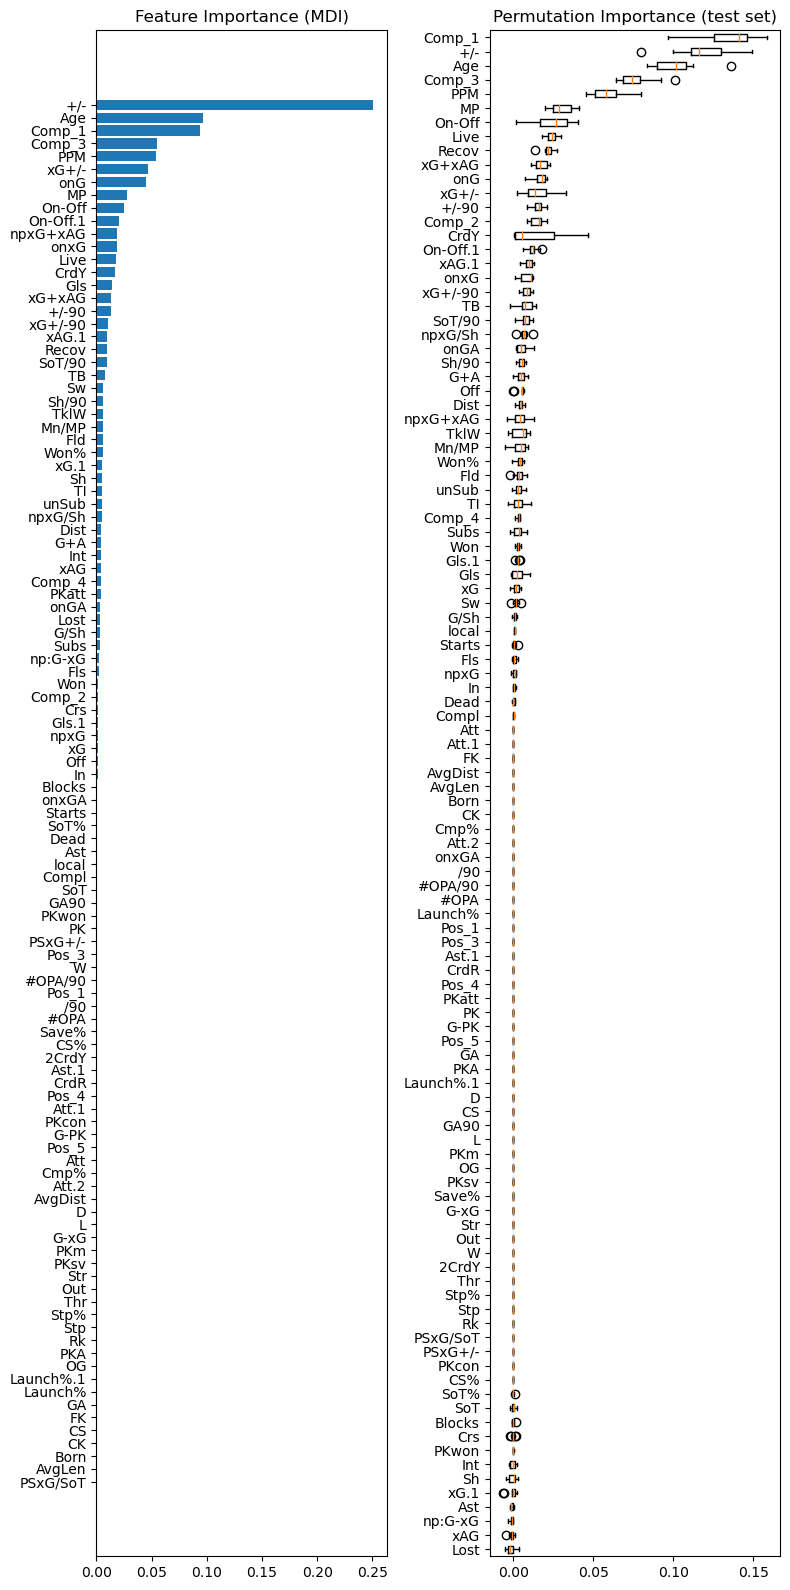

In [301]:
feature_importance = gbrt.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(8, 16))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    gbrt, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()